# UE Localization Pipeline: Visualization Presentation

This notebook generates high-quality visualizations for the UE Localization pipeline. The sections are organized as follows:

1. **Setup & Data Loading** - Load trained model checkpoint and validation data
2. **Input Features** - Table view of radio measurements (RT, PHY, MAC) used by the model
3. **Map Layers** - 10-panel grid showing Radio Map (5 channels) and OSM Map (5 channels)
4. **Model Predictions** - GMM heatmap overlay showing predicted vs ground truth positions
5. **Evaluation Metrics** - Error statistics and distribution analysis (histogram, CDF, box plot)
6. **Loss Decomposition** - Coarse heatmap and Top-K cell probability visualization
7. **Fine Refinement** - Offset magnitudes, uncertainties, and mixture component ellipses
8. **Physics Loss** - Differentiable bilinear resampling and gradient visualization
9. **Position Refinement** - Inference-time optimization trajectory and improvement analysis
10. **Summary** - Comprehensive dashboard with metrics, losses, and CDF comparison

In [1]:
import sys
import os
from pathlib import Path
import yaml
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import importlib

# Get the absolute path to project root
project_root = Path("/home/ubuntu/projects/CellularPositioningResearch")

print(f"Project root: {project_root}")
print(f"Current working directory: {os.getcwd()}")

# Change to project root
os.chdir(project_root)
print(f"Changed to: {os.getcwd()}")

# Add src to path
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Force deep reload of all src modules by removing them from cache first
to_remove = [key for key in sys.modules.keys() if key.startswith('src.')]
for key in to_remove:
    del sys.modules[key]

from src.training import UELocalizationLightning
from src.datasets.radio_dataset import collate_fn

# Set aesthetic style
plt.style.use('seaborn-v0_8-paper')
sns.set_context("talk")

Project root: /home/ubuntu/projects/CellularPositioningResearch
Current working directory: /home/ubuntu/projects/CellularPositioningResearch/notebooks
Changed to: /home/ubuntu/projects/CellularPositioningResearch


## 1. Load Model and Data

We load the trained model from a checkpoint. We patch the configuration to point to a valid dataset for visualization.

## 2. Input Features Overview

The RadioEncoder processes multi-source temporal measurement sequences from cellular network layers. Below is a comprehensive breakdown of all input features, their shapes, and their role in the model.

In [2]:
# Configuration
CHECKPOINT_PATH = "checkpoints/quick_test/last.ckpt"
BASE_CONFIG_PATH = "checkpoints/quick_test/training_config.yaml"

# Find a valid dataset
PROCESSED_DATA_DIR = Path("data/processed/sionna_dataset")
possible_datasets = sorted(list(PROCESSED_DATA_DIR.glob("dataset_*.zarr")))
if possible_datasets:
    DATASET_PATH = str(possible_datasets[-1]) # Use latest
    print(f"Using dataset: {DATASET_PATH}")
else:
    # Fallback
    DATASET_PATH = "data/processed/sionna_dataset_eval/dataset_eval.zarr"

if not os.path.exists(CHECKPOINT_PATH):
    print(f"Warning: Checkpoint {CHECKPOINT_PATH} not found.")
    # Try to find any checkpoint
    ckpts = list(Path("checkpoints").rglob("*.ckpt"))
    if ckpts:
        CHECKPOINT_PATH = str(ckpts[0])
        print(f"Fallback to: {CHECKPOINT_PATH}")

# Patch Config
try:
    with open(BASE_CONFIG_PATH, 'r') as f:
        config = yaml.safe_load(f)
    
    print(f"Patching dataset path in config to: {DATASET_PATH}")
    config['dataset']['train_zarr_paths'] = [DATASET_PATH]
    if 'test_zarr_path' in config['dataset']:
        config['dataset']['test_zarr_path'] = DATASET_PATH
    if 'val_zarr_path' in config['dataset']:
        config['dataset']['val_zarr_path'] = DATASET_PATH
    
    TEMP_CONFIG_PATH = "notebooks/temp_viz_config.yaml"
    with open(TEMP_CONFIG_PATH, 'w') as f:
        yaml.dump(config, f)

    # Load Model
    print(f"Loading model from: {CHECKPOINT_PATH}")
    model = UELocalizationLightning.load_from_checkpoint(
        CHECKPOINT_PATH, 
        config_path=TEMP_CONFIG_PATH,
        strict=False # Allow minor mismatches
    )
    model.eval()
    model.cuda() if torch.cuda.is_available() else model.cpu()

finally:
    if os.path.exists(TEMP_CONFIG_PATH):
        os.remove(TEMP_CONFIG_PATH)

# Setup Data
# We manually setup the dataloader from the config in the checkpoint
val_loader = model.val_dataloader()

# Collect multiple batches and find one with diverse positions
print("Searching for a batch with diverse positions...")
batch_iter = iter(val_loader)
best_batch = None
best_diversity = 0

for batch_idx in range(min(20, len(val_loader))):  # Check up to 20 batches
    try:
        batch = next(batch_iter)
    except StopIteration:
        break
    
    positions = batch['position'].numpy()
    # Measure diversity as range in both X and Y
    x_range = positions[:, 0].max() - positions[:, 0].min()
    y_range = positions[:, 1].max() - positions[:, 1].min()
    diversity = x_range + y_range
    
    if diversity > best_diversity:
        best_diversity = diversity
        best_batch = batch
        best_batch_idx = batch_idx
    
    # If we found a batch with good diversity, use it
    if diversity > 0.2:  # At least 20% of scene covered
        print(f"Found diverse batch at index {batch_idx}")
        break

if best_batch is not None:
    batch = best_batch
    print(f"Using batch {best_batch_idx} with diversity {best_diversity:.3f}")
else:
    print("Warning: Could not find diverse batch, using last available")

# Move batch to device
device = model.device
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)
    elif isinstance(v, dict):
        for sub_k, sub_v in v.items():
            if isinstance(sub_v, torch.Tensor):
                v[sub_k] = sub_v.to(device)

# Show position distribution in this batch
positions = batch['position'].cpu().numpy()
print(f"\nLoaded batch with {positions.shape[0]} samples")
print(f"Position range in batch:")
print(f"  X: [{positions[:,0].min():.3f}, {positions[:,0].max():.3f}] (range: {positions[:,0].max() - positions[:,0].min():.3f})")
print(f"  Y: [{positions[:,1].min():.3f}, {positions[:,1].max():.3f}] (range: {positions[:,1].max() - positions[:,1].min():.3f})")

# Print individual sample positions
print(f"\nSample positions:")
for i, pos in enumerate(positions):
    print(f"  Sample {i}: ({pos[0]:.4f}, {pos[1]:.4f})")

Using dataset: data/processed/sionna_dataset/dataset_20260107_144332.zarr
Fallback to: checkpoints/optimized_run/model-epoch=00-train_loss_epoch=nan.ckpt


NameError: name 'TEMP_CONFIG_PATH' is not defined

In [4]:
# Display real input features from a sample in the batch
sample_idx = 0
measurements = batch['measurements']

# Get actual dimensions from the data
B = measurements['cell_ids'].shape[0]
L = measurements['cell_ids'].shape[1]
rt_dim = measurements['rt_features'].shape[-1]
phy_dim = measurements['phy_features'].shape[-1]
mac_dim = measurements['mac_features'].shape[-1]

# Check if CFR is available
has_cfr = 'cfr_magnitude' in measurements and measurements['cfr_magnitude'] is not None
if has_cfr:
    cfr_shape = measurements['cfr_magnitude'].shape
    cfr_cells, cfr_subcarriers = cfr_shape[-2], cfr_shape[-1]
else:
    cfr_cells, cfr_subcarriers = 8, 64

# Get sequence length for the sample (count valid measurements)
mask = measurements['mask'][sample_idx]
valid_seq_len = mask.sum().item()

print("=" * 120)
print("RADIO ENCODER INPUT FEATURES - REAL DATA SAMPLE")
print("=" * 120)
print(f"\nBatch Configuration:")
print(f"  • Batch Size: {B}")
print(f"  • Max Sequence Length: {L}")
print(f"  • Valid Measurements in Sample {sample_idx}: {valid_seq_len}")
print(f"  • Model Hidden Dimension: 512")
print(f"  • Embedding Dimension (d/4): 128")
print(f"\n")

# Create detailed feature table with REAL VALUES
print("┌" + "─" * 118 + "┐")
print("│ EMBEDDINGS (Categorical → Learned 128-dim vectors)                                                            │")
print("├" + "─" * 118 + "┤")

# Show first few timesteps
timesteps_to_show = min(3, valid_seq_len)
for t in range(timesteps_to_show):
    cell_id = measurements['cell_ids'][sample_idx, t].item()
    beam_id = measurements['beam_ids'][sample_idx, t].item()
    timestamp = measurements['timestamps'][sample_idx, t].item()
    
    print(f"│ Timestep {t}: Cell ID = {cell_id:<6} | Beam ID = {beam_id:<6} | Timestamp = {timestamp:>8.3f}                        │")

print("│   → Each embedded to 128-dim vectors via learned lookup tables                                                │")
print("│   → Timestamp uses sinusoidal positional encoding: sin/cos of scaled time                                     │")
print("└" + "─" * 118 + "┘")

print()
print("┌" + "─" * 118 + "┐")
print(f"│ RT LAYER FEATURES ({rt_dim} features from Sionna Ray-Tracing) - First valid measurement                               │")
print("├" + "─" * 118 + "┤")

rt_feature_names = [
    'Path Gains', 'Path Delays', 'AoA Azimuth', 'AoA Elevation', 
    'AoD Azimuth', 'AoD Elevation', 'Doppler', 'RMS Delay Spread',
    'K-Factor', 'Num Paths', 'ToA', 'Is NLoS', 'RMS Angular Spread'
]
rt_values = measurements['rt_features'][sample_idx, 0, :rt_dim].cpu().numpy()
for i, (name, val) in enumerate(zip(rt_feature_names[:rt_dim], rt_values)):
    print(f"│ [{i:2d}] {name:<25} = {val:>10.4f}                                                           │")
print("│   → All 13 features projected to 128-dim via Linear(13→128) + LayerNorm                                       │")
print("└" + "─" * 118 + "┘")

print()
print("┌" + "─" * 118 + "┐")
print(f"│ PHY LAYER FEATURES ({phy_dim} features from Physical Layer - FAPI) - First valid measurement                         │")
print("├" + "─" * 118 + "┤")

phy_feature_names = [
    'RSRP (dBm)', 'RSRQ', 'SINR (dB)', 'CQI', 
    'RI', 'PMI', 'Capacity (Mbps)', 'Condition Number'
]
phy_values = measurements['phy_features'][sample_idx, 0, :phy_dim].cpu().numpy()
for i, (name, val) in enumerate(zip(phy_feature_names[:phy_dim], phy_values)):
    print(f"│ [{i:2d}] {name:<25} = {val:>10.4f}                                                           │")
print("│   → All 8 features projected to 128-dim via Linear(8→128) + LayerNorm                                         │")
print("└" + "─" * 118 + "┘")

print()
print("┌" + "─" * 118 + "┐")
print(f"│ MAC LAYER FEATURES ({mac_dim} features from MAC/RRC) - First valid measurement                                        │")
print("├" + "─" * 118 + "┤")

mac_feature_names = [
    'Serving Cell ID', 'Timing Advance', 'Power Headroom (dB)', 
    'Throughput (Mbps)', 'BLER (%)'
]
mac_values = measurements['mac_features'][sample_idx, 0, :mac_dim].cpu().numpy()
for i, (name, val) in enumerate(zip(mac_feature_names[:mac_dim], mac_values)):
    print(f"│ [{i:2d}] {name:<25} = {val:>10.4f}                                                           │")
print("│   → All 5 features projected to 128-dim via Linear(5→128) + LayerNorm                                         │")
print("└" + "─" * 118 + "┘")

print()
if has_cfr:
    print("┌" + "─" * 118 + "┐")
    print(f"│ CFR (Channel Frequency Response from DMRS) [{cfr_cells}×{cfr_subcarriers}]                                                     │")
    print("├" + "─" * 118 + "┤")
    cfr_data = measurements['cfr_magnitude'][sample_idx].cpu().numpy()
    print(f"│ Shape: [{cfr_cells} cells, {cfr_subcarriers} subcarriers]                                                                      │")
    print(f"│ Mean magnitude: {cfr_data.mean():>8.4f}  |  Std: {cfr_data.std():>8.4f}  |  Max: {cfr_data.max():>8.4f}                              │")
    print(f"│ Sample values (first 8 subcarriers of cell 0): {str(cfr_data[0, :8]):<45}  │")
    print("│   → Encoded via 1D convolutions along frequency axis → Global pooling → Linear projection to 128-dim       │")
    print("└" + "─" * 118 + "┘")
    print()
else:
    print("┌" + "─" * 118 + "┐")
    print("│ CFR (Channel Frequency Response) - NOT AVAILABLE IN THIS DATASET                                              │")
    print("└" + "─" * 118 + "┘")
    print()

print("┌" + "─" * 118 + "┐")
print("│ ENCODER ARCHITECTURE - DATA FLOW                                                                               │")
print("├" + "─" * 118 + "┤")
print(f"│ 1. Embeddings + Feature Projections:                                                                          │")
print(f"│    • Cell ID Embedding:      [B={B}, L={valid_seq_len}] → [B, L, 128]                                                 │")
print(f"│    • Beam ID Embedding:      [B={B}, L={valid_seq_len}] → [B, L, 128]                                                 │")
print(f"│    • Timestamp Encoding:     [B={B}, L={valid_seq_len}] → [B, L, 128]  (sinusoidal)                                   │")
print(f"│    • RT Features Projection: [B={B}, L={valid_seq_len}, {rt_dim}] → [B, L, 128]                                            │")
print(f"│    • PHY Features Projection:[B={B}, L={valid_seq_len}, {phy_dim}] → [B, L, 128]                                             │")
print(f"│    • MAC Features Projection:[B={B}, L={valid_seq_len}, {mac_dim}] → [B, L, 128]                                              │")
if has_cfr:
    print(f"│    • CFR Encoding:           [B={B}, {cfr_cells}, {cfr_subcarriers}] → [B, 128] (broadcast to [B, L, 128])                          │")
    num_streams = 7
else:
    num_streams = 6
print(f"│                                                                                                                │")
print(f"│ 2. Concatenation:            {num_streams} streams → [B, L, {num_streams}×128={num_streams*128}]                                                    │")
print(f"│                                                                                                                │")
print(f"│ 3. Linear Projection:        [B, L, {num_streams*128}] → [B, L, 512]                                                          │")
print(f"│                                                                                                                │")
print(f"│ 4. Prepend CLS Token:        [B, L, 512] → [B, L+1, 512]                                                      │")
print(f"│                                                                                                                │")
print(f"│ 5. Transformer Encoder:      6 layers, 8 heads, masked self-attention                                         │")
print(f"│                              [B, L+1, 512] → [B, L+1, 512]                                                     │")
print(f"│                                                                                                                │")
print(f"│ 6. Extract CLS Token:        [B, L+1, 512] → [B, 512]  ← Final sequence embedding                             │")
print("└" + "─" * 118 + "┘")

print()
print("Summary:")
print(f"  • Input: {rt_dim + phy_dim + mac_dim} raw features + 2 IDs + 1 timestamp" + (" + 1 CFR matrix" if has_cfr else ""))
print(f"  • Processing: {num_streams} parallel embedding streams")
print(f"  • Output: Single 512-dim vector representing the measurement sequence")
print(f"  • Sequence length: Variable (1 to 20), this sample has {valid_seq_len} valid measurements")
print("=" * 120)

RADIO ENCODER INPUT FEATURES - REAL DATA SAMPLE

Batch Configuration:
  • Batch Size: 8
  • Max Sequence Length: 1
  • Valid Measurements in Sample 0: 1
  • Model Hidden Dimension: 512
  • Embedding Dimension (d/4): 128


┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ EMBEDDINGS (Categorical → Learned 128-dim vectors)                                                            │
├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ Timestep 0: Cell ID = 0      | Beam ID = 0      | Timestamp =    0.000                        │
│   → Each embedded to 128-dim vectors via learned lookup tables                                                │
│   → Timestamp uses sinusoidal positional encoding: sin/cos of scaled time                                     │
└───────────────────────────────────────────────────────────────────────────────────────────────

## 3. Complete Input Feature Table

**All Radio Encoder Inputs (Normalized)**

Displays **ALL** input features to the RadioEncoder for a single sample. Values are shown in **normalized form** (zero-mean, unit-variance) as fed to the neural network.

### Feature Layers (30 total + IDs):

| Layer | Features | Source |
|-------|----------|--------|
| **RT** (13-16) | Path Gains, Delays, AoA/AoD (Az/El), Doppler, RMS-DS, K-Factor, NumPaths, ToA, IsNLOS | Sionna Ray-Tracing |
| **PHY** (8) | RSRP, RSRQ, SINR, CQI, RI, PMI, Capacity, Condition Number | L1 FAPI / PHY Layer |
| **MAC** (5-6) | Serving Cell ID, Timing Advance, PHR, Throughput, BLER | MAC/RRC Layer |
| **IDs** (3) | Cell ID, Beam ID, Timestamp | Categorical / Temporal |
| **CFR** (optional) | Channel Frequency Response [Cells × Subcarriers] | DMRS Channel Estimates |

In [20]:
# Complete Input Feature Sequence Visualization
# Shows ALL features from the dataset schema (both normalized and original scale)

def visualize_all_features(batch, sample_idx=0, model=None):
    """Display ALL input features in structured tables matching the dataset schema."""
    measurements = batch['measurements']
    
    # Extract data for the sample
    mask = measurements['mask'][sample_idx].cpu().numpy()
    seq_len = int(mask.sum())  # Only take valid steps
    
    if seq_len == 0:
        print("⚠️ No valid measurements in this sample!")
        return None
    
    # === FEATURE SCHEMAS (matching RadioLocalizationDataset) ===
    RT_FEATURE_NAMES = [
        ('Path Gains', 'dB'),           # 0
        ('Path Delays', 'ns'),          # 1
        ('AoA Azimuth', '°'),           # 2
        ('AoA Elevation', '°'),         # 3
        ('AoD Azimuth', '°'),           # 4
        ('AoD Elevation', '°'),         # 5
        ('Doppler', 'Hz'),              # 6
        ('RMS Delay Spread', 'ns'),     # 7
        ('K-Factor', 'dB'),             # 8
        ('Num Paths', ''),              # 9
        ('ToA', 's'),                   # 10
        ('Is NLOS', ''),                # 11
        ('RMS Angular Spread', '°'),    # 12
    ]
    
    PHY_FEATURE_NAMES = [
        ('RSRP', 'dBm'),                # 0 - Reference Signal Received Power
        ('RSRQ', 'dB'),                 # 1 - Reference Signal Received Quality
        ('SINR', 'dB'),                 # 2 - Signal-to-Interference-plus-Noise Ratio
        ('CQI', ''),                    # 3 - Channel Quality Indicator (0-15)
        ('RI', ''),                     # 4 - Rank Indicator (1-8)
        ('PMI', ''),                    # 5 - Precoding Matrix Indicator
        ('Capacity', 'Mbps'),           # 6 - Achievable capacity
        ('Condition Number', ''),       # 7 - Channel matrix condition
    ]
    
    MAC_FEATURE_NAMES = [
        ('Serving Cell ID', ''),        # 0
        ('Timing Advance', ''),         # 1
        ('PHR', 'dB'),                  # 2 - Power Headroom Report
        ('Throughput', 'Mbps'),         # 3
        ('BLER', '%'),                  # 4 - Block Error Rate
    ]
    
    # Get actual dimensions from data
    rt_dim = measurements['rt_features'].shape[-1]
    phy_dim = measurements['phy_features'].shape[-1]
    mac_dim = measurements['mac_features'].shape[-1]
    
    print("=" * 110)
    print(f"COMPLETE INPUT FEATURE SEQUENCE (Sample {sample_idx})")
    print("=" * 110)
    print(f"Valid Timesteps: {seq_len} | RT Features: {rt_dim} | PHY Features: {phy_dim} | MAC Features: {mac_dim}")
    print()
    print("⚠️  NOTE: Values shown are NORMALIZED (zero-mean, unit-variance) for neural network training.")
    print("    Original scale values would require denormalization using stored statistics.")
    print()
    
    # === 1. IDENTIFIERS & TIMESTAMPS ===
    print("┌" + "─" * 108 + "┐")
    print("│ 1. IDENTIFIERS & TIMESTAMPS                                                                              │")
    print("├" + "─" * 108 + "┤")
    
    id_data = {
        'Step': list(range(seq_len)),
        'Timestamp': measurements['timestamps'][sample_idx, :seq_len].cpu().numpy(),
        'Cell ID': measurements['cell_ids'][sample_idx, :seq_len].cpu().numpy(),
        'Beam ID': measurements['beam_ids'][sample_idx, :seq_len].cpu().numpy(),
    }
    df_ids = pd.DataFrame(id_data)
    display(df_ids.style.set_caption("Identifiers (Not Normalized)"))
    print("└" + "─" * 108 + "┘")
    print()
    
    # === 2. RT LAYER FEATURES ===
    print("┌" + "─" * 108 + "┐")
    print(f"│ 2. RT LAYER FEATURES - Sionna Ray-Tracing [{rt_dim} features]                                              │")
    print("│    Source: Sionna channel model - path gains, delays, angles from multipath propagation                  │")
    print("├" + "─" * 108 + "┤")
    
    rt_values = measurements['rt_features'][sample_idx, :seq_len, :].cpu().numpy()
    rt_data = {'Step': list(range(seq_len))}
    
    for i in range(min(rt_dim, len(RT_FEATURE_NAMES))):
        name, unit = RT_FEATURE_NAMES[i]
        col_name = f"{name} ({unit})" if unit else name
        rt_data[col_name] = rt_values[:, i]
    
    # Add any extra features beyond schema
    for i in range(len(RT_FEATURE_NAMES), rt_dim):
        rt_data[f'RT[{i}]'] = rt_values[:, i]
    
    df_rt = pd.DataFrame(rt_data)
    styled_rt = df_rt.style.background_gradient(cmap='RdYlGn', axis=0, subset=df_rt.columns[1:]).format(precision=4)
    styled_rt = styled_rt.set_caption("RT Features (Normalized)")
    display(styled_rt)
    print("└" + "─" * 108 + "┘")
    print()
    
    # === 3. PHY LAYER FEATURES ===
    print("┌" + "─" * 108 + "┐")
    print(f"│ 3. PHY LAYER FEATURES - Physical Layer / FAPI [{phy_dim} features]                                        │")
    print("│    Source: L1 PHY layer measurements - signal quality indicators from UE                                 │")
    print("├" + "─" * 108 + "┤")
    
    phy_values = measurements['phy_features'][sample_idx, :seq_len, :].cpu().numpy()
    phy_data = {'Step': list(range(seq_len))}
    
    for i in range(min(phy_dim, len(PHY_FEATURE_NAMES))):
        name, unit = PHY_FEATURE_NAMES[i]
        col_name = f"{name} ({unit})" if unit else name
        phy_data[col_name] = phy_values[:, i]
    
    for i in range(len(PHY_FEATURE_NAMES), phy_dim):
        phy_data[f'PHY[{i}]'] = phy_values[:, i]
    
    df_phy = pd.DataFrame(phy_data)
    styled_phy = df_phy.style.background_gradient(cmap='Blues', axis=0, subset=df_phy.columns[1:]).format(precision=4)
    styled_phy = styled_phy.set_caption("PHY Features (Normalized)")
    display(styled_phy)
    print("└" + "─" * 108 + "┘")
    print()
    
    # === 4. MAC LAYER FEATURES ===
    print("┌" + "─" * 108 + "┐")
    print(f"│ 4. MAC LAYER FEATURES - MAC/RRC Layer [{mac_dim} features]                                                 │")
    print("│    Source: Higher layer reports - timing advance, throughput, cell selection                             │")
    print("├" + "─" * 108 + "┤")
    
    mac_values = measurements['mac_features'][sample_idx, :seq_len, :].cpu().numpy()
    mac_data = {'Step': list(range(seq_len))}
    
    for i in range(min(mac_dim, len(MAC_FEATURE_NAMES))):
        name, unit = MAC_FEATURE_NAMES[i]
        col_name = f"{name} ({unit})" if unit else name
        mac_data[col_name] = mac_values[:, i]
    
    for i in range(len(MAC_FEATURE_NAMES), mac_dim):
        mac_data[f'MAC[{i}]'] = mac_values[:, i]
    
    df_mac = pd.DataFrame(mac_data)
    styled_mac = df_mac.style.background_gradient(cmap='Oranges', axis=0, subset=df_mac.columns[1:]).format(precision=4)
    styled_mac = styled_mac.set_caption("MAC Features (Normalized)")
    display(styled_mac)
    print("└" + "─" * 108 + "┘")
    print()
    
    # === 5. CFR (Channel Frequency Response) ===
    has_cfr = 'cfr_magnitude' in measurements and measurements['cfr_magnitude'] is not None
    if has_cfr:
        cfr = measurements['cfr_magnitude'][sample_idx].cpu().numpy()
        if cfr.sum() != 0:  # Check if CFR has actual data
            print("┌" + "─" * 108 + "┐")
            print(f"│ 5. CFR - Channel Frequency Response [{cfr.shape[0]} cells × {cfr.shape[1]} subcarriers]                              │")
            print("│    Source: Channel estimate from DMRS - encodes distance/multipath info across frequency                 │")
            print("├" + "─" * 108 + "┤")
            
            fig, ax = plt.subplots(figsize=(14, 3))
            im = ax.imshow(cfr, aspect='auto', cmap='viridis')
            ax.set_xlabel('Subcarrier Index')
            ax.set_ylabel('Cell Index')
            ax.set_title(f'CFR Magnitude | Mean: {cfr.mean():.4f} | Std: {cfr.std():.4f}')
            plt.colorbar(im, ax=ax, label='Magnitude (Normalized)')
            plt.tight_layout()
            plt.show()
            print("└" + "─" * 108 + "┘")
        else:
            print("│ CFR: Shape available but values are zeros (placeholder)                                              │")
    else:
        print("┌" + "─" * 108 + "┐")
        print("│ 5. CFR: Not available in this dataset                                                                  │")
        print("└" + "─" * 108 + "┘")
    
    # === SUMMARY TABLE ===
    print()
    print("┌" + "─" * 108 + "┐")
    print("│ FEATURE SUMMARY                                                                                          │")
    print("├" + "─" * 108 + "┤")
    
    summary_data = []
    
    # RT features summary
    for i, (name, unit) in enumerate(RT_FEATURE_NAMES[:min(rt_dim, len(RT_FEATURE_NAMES))]):
        vals = rt_values[:, i]
        summary_data.append({
            'Layer': 'RT',
            'Index': i,
            'Feature': name,
            'Unit': unit,
            'Min': vals.min(),
            'Max': vals.max(),
            'Mean': vals.mean(),
            'Std': vals.std()
        })
    
    # PHY features summary
    for i, (name, unit) in enumerate(PHY_FEATURE_NAMES[:min(phy_dim, len(PHY_FEATURE_NAMES))]):
        vals = phy_values[:, i]
        summary_data.append({
            'Layer': 'PHY',
            'Index': i,
            'Feature': name,
            'Unit': unit,
            'Min': vals.min(),
            'Max': vals.max(),
            'Mean': vals.mean(),
            'Std': vals.std()
        })
    
    # MAC features summary
    for i, (name, unit) in enumerate(MAC_FEATURE_NAMES[:min(mac_dim, len(MAC_FEATURE_NAMES))]):
        vals = mac_values[:, i]
        summary_data.append({
            'Layer': 'MAC',
            'Index': i,
            'Feature': name,
            'Unit': unit,
            'Min': vals.min(),
            'Max': vals.max(),
            'Mean': vals.mean(),
            'Std': vals.std()
        })
    
    df_summary = pd.DataFrame(summary_data)
    styled_summary = df_summary.style.format({
        'Min': '{:.4f}', 'Max': '{:.4f}', 'Mean': '{:.4f}', 'Std': '{:.4f}'
    }).set_caption("All Features Summary (Normalized Values)")
    display(styled_summary)
    
    print("└" + "─" * 108 + "┘")
    print()
    print("=" * 110)
    print(f"TOTAL: {rt_dim + phy_dim + mac_dim} scalar features + 3 IDs per timestep" + 
          (f" + CFR [{cfr.shape[0]}×{cfr.shape[1]}]" if has_cfr and cfr.sum() != 0 else ""))
    print("=" * 110)
    
    return {
        'identifiers': df_ids,
        'rt_features': df_rt,
        'phy_features': df_phy, 
        'mac_features': df_mac,
        'summary': df_summary
    }

# Run visualization
feature_tables = visualize_all_features(batch, sample_idx=0, model=model)

COMPLETE INPUT FEATURE SEQUENCE (Sample 0)
Valid Timesteps: 1 | RT Features: 16 | PHY Features: 8 | MAC Features: 6

⚠️  NOTE: Values shown are NORMALIZED (zero-mean, unit-variance) for neural network training.
    Original scale values would require denormalization using stored statistics.

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ 1. IDENTIFIERS & TIMESTAMPS                                                                              │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────┤


,Step,Timestamp,Cell ID,Beam ID
0,0,0.000000,0,0


└────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ 2. RT LAYER FEATURES - Sionna Ray-Tracing [16 features]                                              │
│    Source: Sionna channel model - path gains, delays, angles from multipath propagation                  │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────┤


,Step,Path Gains (dB),Path Delays (ns),AoA Azimuth (°),AoA Elevation (°),AoD Azimuth (°),AoD Elevation (°),Doppler (Hz),RMS Delay Spread (ns),K-Factor (dB),Num Paths,ToA (s),Is NLOS,RMS Angular Spread (°),RT[13],RT[14],RT[15]
0,0,2.6453,-0.3844,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0566,0.0000,-0.0897,-2.6640,0.0000,0.2841,0.0000,0.0000,0.0000


└────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ 3. PHY LAYER FEATURES - Physical Layer / FAPI [8 features]                                        │
│    Source: L1 PHY layer measurements - signal quality indicators from UE                                 │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────┤


,Step,RSRP (dBm),RSRQ (dB),SINR (dB),CQI,RI,PMI,Capacity (Mbps),Condition Number
0,0,-0.0000,3.8037,3.4963,-0.2582,-0.2582,0.0000,0.0000,1.0000


└────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ 4. MAC LAYER FEATURES - MAC/RRC Layer [6 features]                                                 │
│    Source: Higher layer reports - timing advance, throughput, cell selection                             │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────┤


,Step,Serving Cell ID,Timing Advance,PHR (dB),Throughput (Mbps),BLER (%),MAC[5]
0,0,-0.0019,-0.5842,0.0000,0.0000,0.0000,0.0000


└────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ 5. CFR: Not available in this dataset                                                                  │
└────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ FEATURE SUMMARY                                                                                          │
├────────────────────────────────────────────────────────────────────────────────────────────────────────────┤


,Layer,Index,Feature,Unit,Min,Max,Mean,Std
0,RT,0,Path Gains,dB,2.6453,2.6453,2.6453,0.0000
1,RT,1,Path Delays,ns,-0.3844,-0.3844,-0.3844,0.0000
2,RT,2,AoA Azimuth,°,0.0000,0.0000,0.0000,0.0000
3,RT,3,AoA Elevation,°,0.0000,0.0000,0.0000,0.0000
4,RT,4,AoD Azimuth,°,0.0000,0.0000,0.0000,0.0000
5,RT,5,AoD Elevation,°,0.0000,0.0000,0.0000,0.0000
6,RT,6,Doppler,Hz,0.0000,0.0000,0.0000,0.0000
7,RT,7,RMS Delay Spread,ns,-0.0566,-0.0566,-0.0566,0.0000
8,RT,8,K-Factor,dB,0.0000,0.0000,0.0000,0.0000
9,RT,9,Num Paths,,-0.0897,-0.0897,-0.0897,0.0000


└────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

TOTAL: 30 scalar features + 3 IDs per timestep


## 4. Visualize Map Layers

**Plot: 2×5 Grid of Map Channels**

Shows the 10-channel map input to the MapEncoder:

**Radio Map (5 channels)**: Ray-tracing derived channel predictions
- CH0: Path Loss, CH1: RSRP, CH2: Delay Spread, CH3: K-Factor, CH4: AoA

**OSM Map (5 channels)**: OpenStreetMap-derived urban geometry
- CH0: Building Height, CH1: Building Footprint, CH2: Roads, CH3: Distance Transform, CH4: Edges

These multi-channel maps provide spatial context for the positioning task.

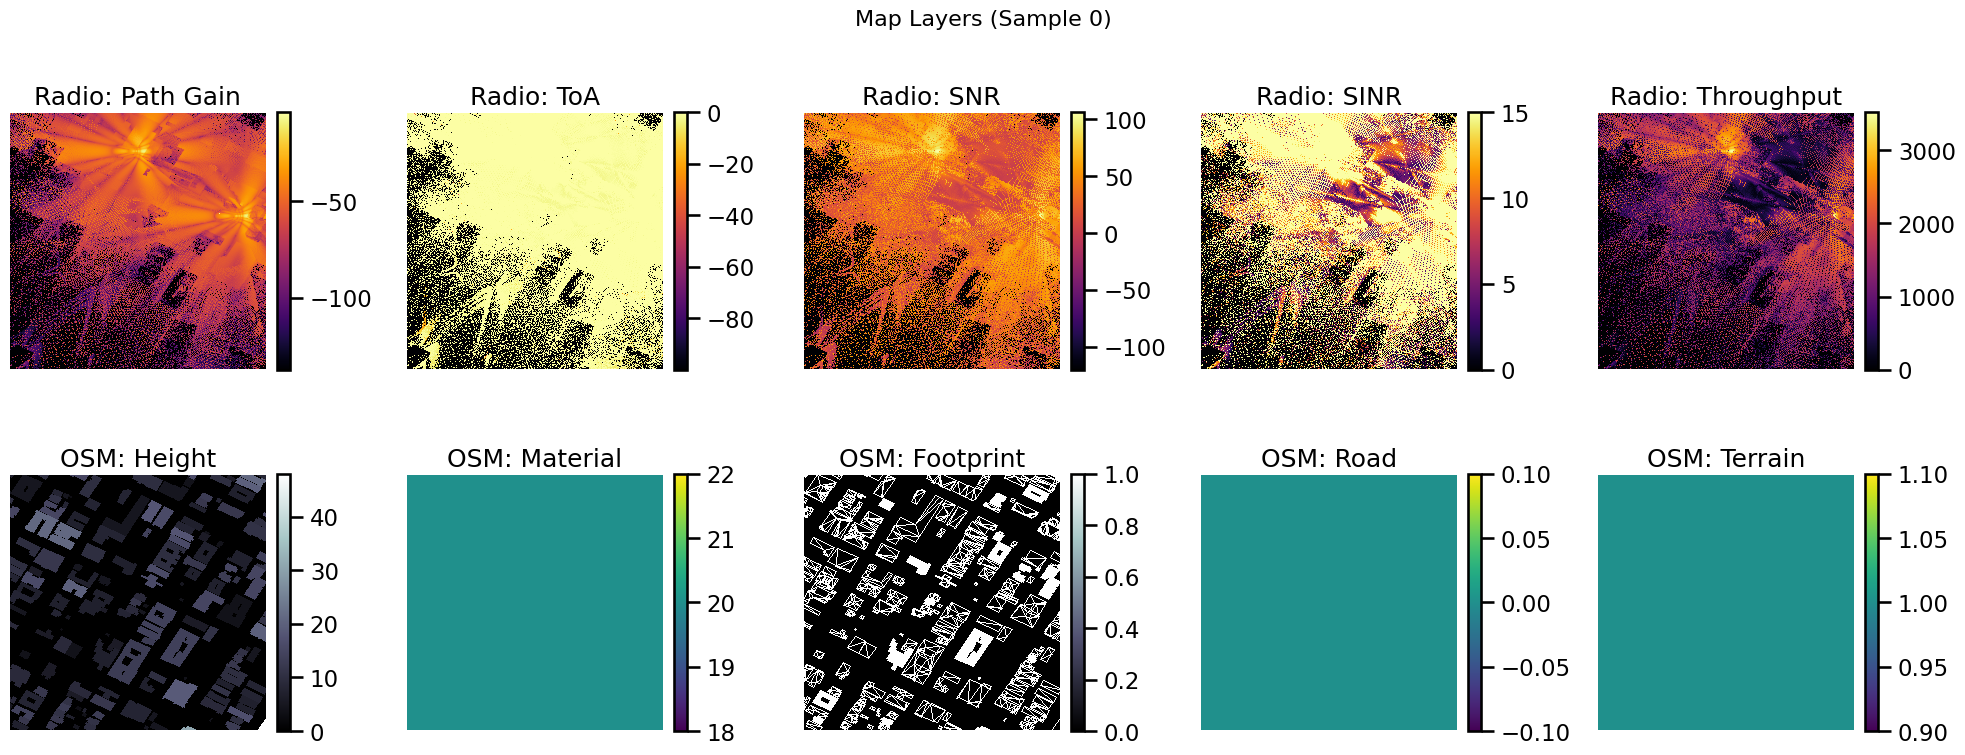

In [6]:
def visualize_maps(batch, sample_idx=0):
    radio_map = batch['radio_map'][sample_idx].cpu().numpy()
    osm_map = batch['osm_map'][sample_idx].cpu().numpy()
    
    # Radio Map Channels: ['Path Gain', 'ToA', 'SNR', 'SINR', 'Throughput']
    # OSM Map Channels: ['Height', 'Material', 'Footprint', 'Road', 'Terrain']
    # Note: Material (1), Road (3), Terrain (4) are often constant/empty but included for compat
    
    num_osm_channels = osm_map.shape[0]
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    # Plot Radio Maps - use origin='lower' so (0,0) is bottom-left matching position coords
    radio_titles = ['Path Gain', 'ToA', 'SNR', 'SINR', 'Throughput']
    for i in range(5):
        im = axes[0, i].imshow(radio_map[i], cmap='inferno', origin='lower')
        axes[0, i].set_title(f"Radio: {radio_titles[i]}")
        axes[0, i].axis('off')
        plt.colorbar(im, ax=axes[0, i], fraction=0.046, pad=0.04)

    # Plot OSM Maps (all 5 channels for backward compatibility)
    osm_titles = ['Height', 'Material', 'Footprint', 'Road', 'Terrain']
    for i in range(min(num_osm_channels, 5)):
        cmap = 'bone' if i in [0, 2] else 'viridis'
        im = axes[1, i].imshow(osm_map[i], cmap=cmap, origin='lower')
        axes[1, i].set_title(f"OSM: {osm_titles[i]}")
        axes[1, i].axis('off')
        plt.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)
    
    # Hide unused subplot axes if fewer channels
    for i in range(num_osm_channels, 5):
        axes[1, i].axis('off')
        axes[1, i].set_title("(Not Used)")
    
    plt.suptitle(f"Map Layers (Sample {sample_idx})", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_maps(batch)

### 📊 Interpretation: Map Visualization

**What to look for:**
- **Radio Map Coverage**: Path gain should show clear signal decay from transmitters, with shadows behind buildings
- **Consistent Patterns**: ToA, SNR, and SINR should correlate with path gain patterns
- **OSM Map Quality**: Height map should clearly show building footprints; footprint channel should be binary (0 or 1)
- **Alignment**: Radio and OSM maps should spatially align (same scene extent)

**Common Issues:**
- **All zeros in radio map**: Scene may not have loaded properly or transmitters are missing
- **Uniform OSM channels**: Scene may have missing building data or incorrect material assignments
- **Misalignment**: Check that coordinate transformations are consistent between radio and OSM rendering

## 5. Sionna Native 3D Scene Visualization

**Plot: Interactive 3D Scene with Radio Map Overlay**

Uses Sionna's native rendering engine to visualize:
- **3D Building Geometry**: The urban environment from OpenStreetMap
- **Radio Map Coverage**: Path gain heatmap overlaid on the ground plane
- **Transmitter Locations**: Base station positions in the scene
- **UE Position**: Current sample's ground truth location

This provides spatial context for understanding the radio propagation environment.

SIONNA 3D SCENE VISUALIZATION
Found 7 scene files. Using: data/scenes/boulder_colorado/scene_-105.28_40.015/scene.xml
Loading Sionna scene from: data/scenes/boulder_colorado/scene_-105.28_40.015/scene.xml
Scene bounds: (-321.3, -417.2) to (321.3, 417.2), size: 834.4m
UE position (world coords): (-145.8, -268.8, 1.5)
Added transmitter at (-0.0, 0.0, 30.0)
Generating radio map for visualization (this may take a moment)...
Radio map generated successfully!
Rendering 3D scene...
3D scene render successful!
Extracting radio map for visualization...
Radio map visualization successful!


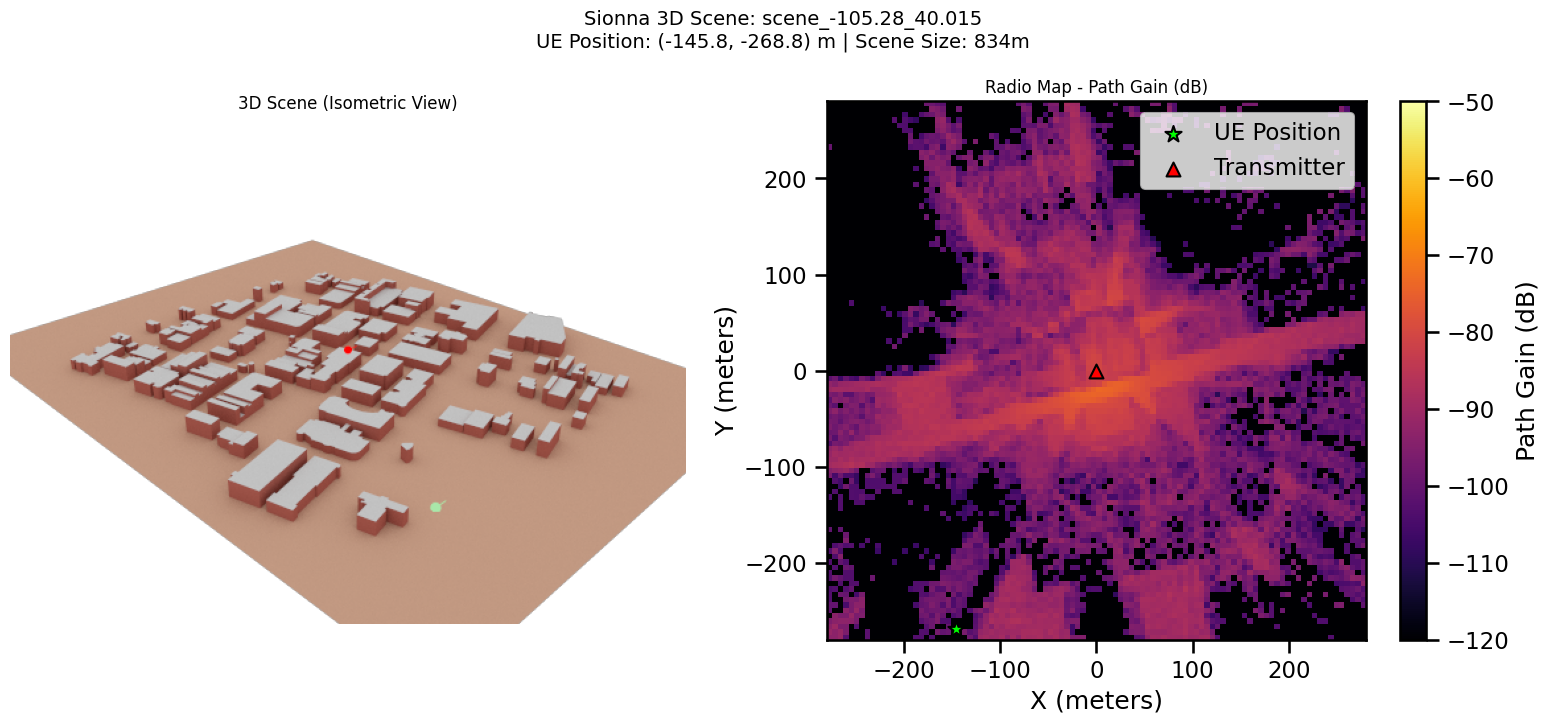

In [7]:
def visualize_sionna_3d_scene(batch, sample_idx=0, scene_path=None):
    """
    Render a 3D visualization of the Sionna scene with radio map overlay.
    
    This uses Sionna's native rendering capabilities to show:
    - 3D building geometry
    - Radio map coverage (path gain)
    - Transmitter and receiver positions
    """
    import io
    from PIL import Image
    
    try:
        import sionna as sn
        from sionna.rt import Camera, load_scene
        
        # Try to find and load the scene
        if scene_path is None:
            # Search recursively for scene.xml files
            scenes_dir = Path("data/scenes")
            scene_files = list(scenes_dir.rglob("scene.xml"))  # Recursive search
            if not scene_files:
                scene_files = list(scenes_dir.rglob("*.xml"))
            if scene_files:
                scene_path = scene_files[0]
                print(f"Found {len(scene_files)} scene files. Using: {scene_path}")
            else:
                print("No scene files found in data/scenes/. Showing fallback visualization.")
                return visualize_radio_map_3d_fallback(batch, sample_idx)
        
        # Load scene
        print(f"Loading Sionna scene from: {scene_path}")
        scene = load_scene(str(scene_path))
        
        # Get scene bounds
        try:
            bbox = scene.mi_scene.bbox()
            x_min, y_min, z_min = bbox.min.x, bbox.min.y, bbox.min.z
            x_max, y_max, z_max = bbox.max.x, bbox.max.y, bbox.max.z
            cx = (x_min + x_max) / 2
            cy = (y_min + y_max) / 2
            max_dim = max(x_max - x_min, y_max - y_min)
            ground_z = z_min
            print(f"Scene bounds: ({x_min:.1f}, {y_min:.1f}) to ({x_max:.1f}, {y_max:.1f}), size: {max_dim:.1f}m")
        except Exception as e:
            print(f"Could not get scene bounds: {e}")
            cx, cy, ground_z = 0, 0, 0
            max_dim = 500
        
        # Get true position from batch and convert to world coordinates
        true_pos = batch['position'][sample_idx].cpu().numpy()
        sample_extent = batch['sample_extent'][sample_idx].item() if 'sample_extent' in batch else 512.0
        
        # Convert normalized position to world coordinates (centered at scene center)
        ue_x = cx + (true_pos[0] - 0.5) * sample_extent
        ue_y = cy + (true_pos[1] - 0.5) * sample_extent
        ue_z = ground_z + 1.5  # UE height
        
        print(f"UE position (world coords): ({ue_x:.1f}, {ue_y:.1f}, {ue_z:.1f})")
        
        # Add UE as receiver
        rx = sn.rt.Receiver("UE", position=[float(ue_x), float(ue_y), float(ue_z)])
        scene.add(rx)
        
        # Setup camera - isometric view
        iso_dist = max_dim * 0.8
        cam_z = ground_z + max_dim * 0.6
        
        cam = Camera(
            position=[float(cx - iso_dist), float(cy - iso_dist), float(cam_z)],
            look_at=[float(cx), float(cy), float(ground_z)]
        )
        
        # Ensure we have a transmitter
        if len(scene.transmitters) == 0:
            tx = sn.rt.Transmitter("TX_1", position=[float(cx), float(cy), float(ground_z + 30)])
            scene.add(tx)
            print(f"Added transmitter at ({cx:.1f}, {cy:.1f}, {ground_z + 30:.1f})")
        
        scene.tx_array = sn.rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
        scene.rx_array = sn.rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")
        
        # Generate radio map for visualization
        print("Generating radio map for visualization (this may take a moment)...")
        solver = sn.rt.RadioMapSolver()
        
        # Use smaller cell size for faster computation
        map_size = min(sample_extent, max_dim)
        cell_size = max(5.0, map_size / 100)  # At most 100x100 cells
        
        radio_map = solver(
            scene,
            center=[float(cx), float(cy), float(ground_z + 1.5)],
            size=[float(map_size), float(map_size)],
            cell_size=[cell_size, cell_size],
            orientation=[0.0, 0.0, 0.0],
            max_depth=3,  # Reduce for faster computation
            diffraction=False  # Disable for speed
        )
        print("Radio map generated successfully!")
        
        # Create figure for visualization
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        
        # 1. Render scene to file and display
        ax = axes[0]
        ax.set_title("3D Scene (Isometric View)", fontsize=12)
        try:
            print("Rendering 3D scene...")
            # Use render_to_file with a temporary file
            import tempfile
            with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:
                tmp_path = tmp.name
            
            scene.render_to_file(
                camera=cam,
                filename=tmp_path,
                resolution=(512, 384)
            )
            
            # Load and display
            img = plt.imread(tmp_path)
            ax.imshow(img)
            ax.axis('off')
            
            # Cleanup
            os.unlink(tmp_path)
            print("3D scene render successful!")
        except Exception as e:
            print(f"Plain render failed: {e}")
            ax.text(0.5, 0.5, f"3D Render unavailable\n(Mitsuba/GPU required)", ha='center', va='center', 
                    transform=ax.transAxes, fontsize=12)
            ax.set_facecolor('lightgray')
            ax.axis('off')
        
        # 2. Radio map as 2D heatmap (more reliable than 3D overlay)
        ax = axes[1]
        ax.set_title("Radio Map - Path Gain (dB)", fontsize=12)
        try:
            print("Extracting radio map for visualization...")
            # Extract path gain from radio map
            path_gain = radio_map.path_gain
            if hasattr(path_gain, 'numpy'):
                path_gain = path_gain.numpy()
            
            # Convert to dB
            path_gain_db = 10 * np.log10(np.maximum(path_gain, 1e-12))
            
            # Take max over transmitters if multiple
            if path_gain_db.ndim > 2:
                path_gain_2d = np.max(path_gain_db, axis=0)
            else:
                path_gain_2d = path_gain_db
            
            im = ax.imshow(path_gain_2d, cmap='inferno', origin='lower', 
                          extent=[cx - map_size/2, cx + map_size/2, 
                                  cy - map_size/2, cy + map_size/2],
                          vmin=-120, vmax=-50)
            
            # Mark UE position
            ax.scatter([ue_x], [ue_y], c='lime', s=150, marker='*', 
                      edgecolors='black', linewidth=1.5, zorder=10, label='UE Position')
            
            # Mark TX position
            ax.scatter([cx], [cy], c='red', s=100, marker='^', 
                      edgecolors='black', linewidth=1.5, zorder=10, label='Transmitter')
            
            ax.set_xlabel('X (meters)')
            ax.set_ylabel('Y (meters)')
            ax.legend(loc='upper right')
            plt.colorbar(im, ax=ax, label='Path Gain (dB)')
            print("Radio map visualization successful!")
        except Exception as e:
            print(f"Radio map visualization failed: {e}")
            ax.text(0.5, 0.5, f"Radio map extraction failed:\n{str(e)[:60]}", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=10)
            ax.axis('off')
        
        scene_name = Path(scene_path).parent.name if scene_path else "Unknown"
        plt.suptitle(f"Sionna 3D Scene: {scene_name}\nUE Position: ({ue_x:.1f}, {ue_y:.1f}) m | Scene Size: {max_dim:.0f}m", fontsize=14)
        plt.tight_layout()
        
        # Use display() for reliable inline output in Jupyter
        from IPython.display import display
        display(fig)
        plt.close(fig)
        
        # Cleanup
        try:
            scene.remove("UE")
        except:
            pass
        
        return radio_map
        
    except ImportError as e:
        print(f"Sionna not available: {e}")
        print("Falling back to matplotlib 3D visualization...")
        return visualize_radio_map_3d_fallback(batch, sample_idx)
    except Exception as e:
        print(f"Sionna 3D rendering failed: {e}")
        import traceback
        traceback.print_exc()
        print("Falling back to matplotlib 3D visualization...")
        return visualize_radio_map_3d_fallback(batch, sample_idx)


def visualize_radio_map_3d_fallback(batch, sample_idx=0):
    """
    Fallback 3D visualization using matplotlib when Sionna rendering is unavailable.
    Shows the radio map as a 3D surface plot with the OSM height map.
    """
    from mpl_toolkits.mplot3d import Axes3D
    
    radio_map = batch['radio_map'][sample_idx].cpu().numpy()
    osm_map = batch['osm_map'][sample_idx].cpu().numpy()
    true_pos = batch['position'][sample_idx].cpu().numpy()
    
    h, w = radio_map.shape[-2:]
    x = np.linspace(0, 1, w)
    y = np.linspace(0, 1, h)
    X, Y = np.meshgrid(x, y)
    
    # Normalize data for visualization
    path_gain = radio_map[0]  # First channel is path gain
    path_gain_norm = (path_gain - path_gain.min()) / (path_gain.max() - path_gain.min() + 1e-8)
    
    # Get building heights from OSM map (first channel)
    heights = osm_map[0] if osm_map.shape[0] > 0 else np.zeros((h, w))
    heights_norm = (heights - heights.min()) / (heights.max() - heights.min() + 1e-8)
    
    fig = plt.figure(figsize=(16, 6))
    
    # 1. 3D Surface plot of radio map
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(X, Y, path_gain_norm * 0.3, cmap='inferno', alpha=0.8, 
                            linewidth=0, antialiased=True)
    ax1.scatter([true_pos[0]], [true_pos[1]], [0.35], c='lime', s=100, marker='*', 
                edgecolors='black', zorder=10, label='UE Position')
    ax1.set_xlabel('X (normalized)')
    ax1.set_ylabel('Y (normalized)')
    ax1.set_zlabel('Path Gain (normalized)')
    ax1.set_title('Radio Map 3D Surface', fontsize=12)
    ax1.view_init(elev=30, azim=-60)
    fig.colorbar(surf, ax=ax1, shrink=0.5, label='Path Gain')
    
    # 2. Combined height + radio map
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Plot building heights as wireframe
    ax2.plot_wireframe(X, Y, heights_norm * 0.5, color='gray', alpha=0.3, linewidth=0.5)
    
    # Overlay radio map as colored surface at ground level
    surf2 = ax2.plot_surface(X, Y, np.zeros_like(path_gain_norm), 
                             facecolors=plt.cm.inferno(path_gain_norm),
                             alpha=0.7, linewidth=0)
    
    ax2.scatter([true_pos[0]], [true_pos[1]], [0.05], c='lime', s=100, marker='*', 
                edgecolors='black', zorder=10, label='UE Position')
    ax2.set_xlabel('X (normalized)')
    ax2.set_ylabel('Y (normalized)')
    ax2.set_zlabel('Height (normalized)')
    ax2.set_title('Buildings + Radio Coverage', fontsize=12)
    ax2.view_init(elev=45, azim=-45)
    ax2.legend()
    
    plt.suptitle(f"3D Visualization (Matplotlib Fallback)\nUE: ({true_pos[0]:.3f}, {true_pos[1]:.3f})", 
                 fontsize=14)
    plt.tight_layout()
    
    # Use display() for reliable inline output in Jupyter
    from IPython.display import display
    display(fig)
    plt.close(fig)
    
    return None


# Run the visualization
print("=" * 60)
print("SIONNA 3D SCENE VISUALIZATION")
print("=" * 60)
sionna_radio_map = visualize_sionna_3d_scene(batch, sample_idx=0)

### 📊 Interpretation: 3D Scene Visualization

**What to look for:**
- **Scene Geometry**: Buildings should be clearly visible with proper heights and shapes
- **Transmitter Placement**: Base stations should be strategically positioned (rooftops or elevated)
- **Radio Coverage**: Path gain heatmap should show realistic propagation patterns (stronger near TXs, shadowing behind buildings)
- **UE Position**: Ground truth location should be within the scene boundaries

**Common Issues:**
- **Missing geometry**: If buildings don't appear, check scene loading or Sionna integration
- **Uniform radio map**: May indicate failed ray tracing or missing transmitter power settings
- **UE outside scene**: Check coordinate transformation between simulation and storage frames
- **No visualization output**: Fallback to matplotlib 3D plot if Sionna native rendering is unavailable

## 4. Model Predictions vs Ground Truth

**Plot: GMM Heatmap Overlay**

Visualizes the model's Gaussian Mixture Model prediction:
- **Background**: OSM map layers (Height=R, Footprint=G, Road+Terrain=B)
- **Overlay**: Turbo colormap showing GMM probability density
- **Green Star**: Ground truth position
- **Red X**: Predicted position (weighted mean of mixture)
- **Dashed Circle**: Uncertainty estimate (σ from top component)

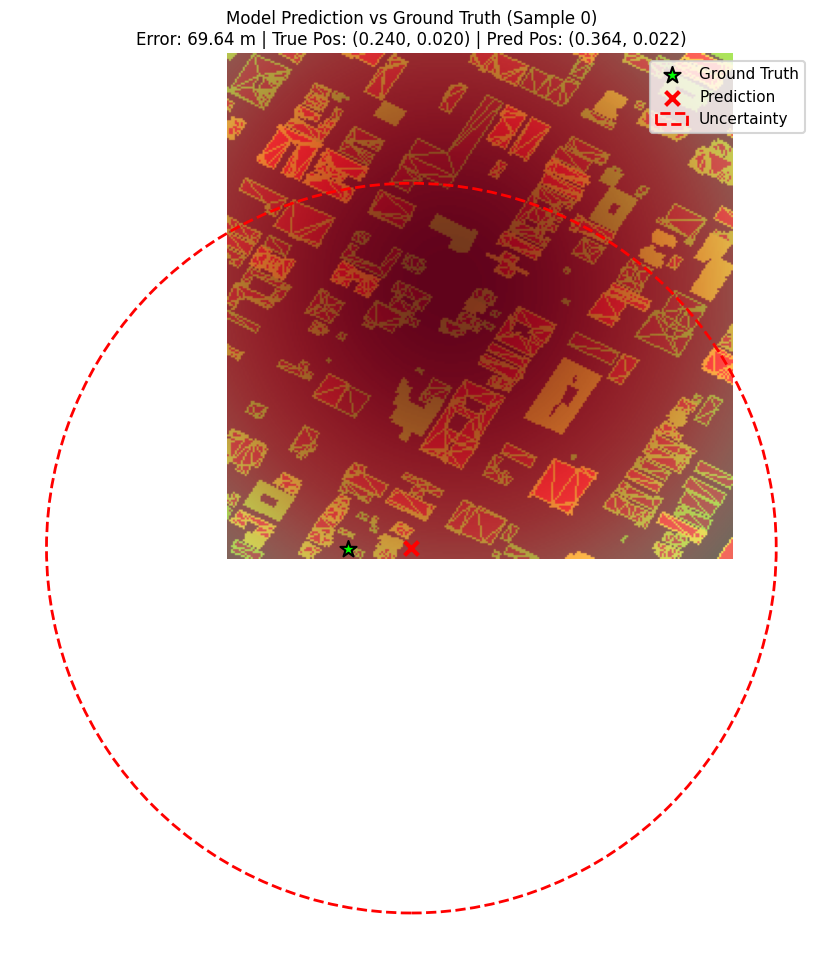

In [8]:
def render_prediction(model, batch, sample_idx=0):
    with torch.no_grad():
        # Use the model's internal model (UELocalizationModel) directly
        outputs = model.model(batch['measurements'], batch['radio_map'], batch['osm_map'])
    
    # Extract outputs for sample
    top_k_indices = outputs['top_k_indices'][sample_idx]
    top_k_probs = outputs['top_k_probs'][sample_idx]
    fine_offsets = outputs['fine_offsets'][sample_idx]
    fine_uncertainties = outputs['fine_uncertainties'][sample_idx]
    pred_pos = outputs['predicted_position'][sample_idx].cpu().numpy()
    true_pos = batch['position'][sample_idx].cpu().numpy()
    
    # Get map dimensions
    h, w = batch['radio_map'].shape[-2:]
    grid_size = model.model.grid_size
    
    # Render GMM Heatmap manually using model's coarse head
    gmm_heatmap = np.zeros((h, w), dtype=np.float32)
    
    # For each top-K component, render a gaussian
    for k in range(min(5, len(top_k_indices))):
        cell_idx = top_k_indices[k].item()
        prob = top_k_probs[k].item()
        offset = fine_offsets[k].cpu().numpy()
        sigma = fine_uncertainties[k].cpu().numpy()  # [σx, σy]
        
        # Cell center (in normalized coords [0, 1])
        # cell_idx is row-major: cell_idx = row * grid_size + col
        cell_col = cell_idx % grid_size
        cell_row = cell_idx // grid_size
        cell_x = (cell_col + 0.5) / grid_size
        cell_y = (cell_row + 0.5) / grid_size
        
        # Add offset (clamped to valid range)
        center_x = np.clip(cell_x + offset[0], 0, 1)
        center_y = np.clip(cell_y + offset[1], 0, 1)
        
        # Convert to pixel coordinates (no Y-flip, using origin='lower')
        cx_px = center_x * w
        cy_px = center_y * h
        
        # Scale sigma to pixels
        sigma_px = np.abs(sigma) * w + 1e-3
        
        # Create coordinate grids for origin='lower' 
        # Row 0 is at y=0 (bottom), row h-1 is at y=h (top)
        y_grid, x_grid = np.ogrid[:h, :w]
        
        # Compute Gaussian
        gauss = np.exp(-0.5 * ((x_grid - cx_px) / sigma_px[0])**2 
                       -0.5 * ((y_grid - cy_px) / sigma_px[1])**2)
        gmm_heatmap += prob * gauss
    
    # Normalize heatmap
    if gmm_heatmap.max() > 0:
        gmm_heatmap /= gmm_heatmap.max()
    
    # Prepare visualization
    # Background: OSM channels - supports both 5-channel (old) and 2-channel (new) formats
    osm_map = batch['osm_map'][sample_idx].cpu().numpy()
    bg = np.zeros((h, w, 3))
    bg[..., 0] = model._normalize_map(osm_map[0])  # Height (R)
    
    # Handle both old (5-channel) and new (2-channel) OSM formats
    if osm_map.shape[0] >= 5:
        # Old format: [Height, Material, Footprint, Road, Terrain]
        bg[..., 1] = model._normalize_map(osm_map[2])  # Footprint (G)
        bg[..., 2] = model._normalize_map(osm_map[3] + osm_map[4] * 0.5)  # Road+Terrain (B)
    elif osm_map.shape[0] >= 2:
        # New format: [Height, Footprint]
        bg[..., 1] = model._normalize_map(osm_map[1])  # Footprint (G)
        bg[..., 2] = 0
    
    # GMM Overlay
    gmm_colored = plt.cm.turbo(gmm_heatmap)
    gmm_colored[..., 3] = np.clip(gmm_heatmap * 0.8, 0, 0.8) # Alpha
    
    # Coordinates (convert normalized [0,1] to pixel coords)
    # Using origin='lower' so no Y-flip needed
    true_px = true_pos[0] * w
    true_py = true_pos[1] * h
    pred_px = pred_pos[0] * w
    pred_py = pred_pos[1] * h
    
    # Compute error in meters (using actual scene extent if available)
    scene_extent = batch['sample_extent'][sample_idx].item() if 'sample_extent' in batch else 512.0
    error_m = np.linalg.norm((true_pos - pred_pos) * scene_extent)
    
    # Plot with origin='lower' for consistent coordinate system
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(bg, origin='lower', extent=[0, w, 0, h])
    ax.imshow(gmm_colored, origin='lower', extent=[0, w, 0, h])
    
    ax.scatter([true_px], [true_py], c='lime', s=150, marker='*', label='Ground Truth', edgecolors='black', zorder=10, linewidth=1.5)
    ax.scatter([pred_px], [pred_py], c='red', s=100, marker='x', label='Prediction', linewidth=3, zorder=10)
    
    # Add uncertainty ellipse (from first component)
    sigma = fine_uncertainties[0].cpu().numpy()
    sigma_px = np.abs(sigma) * w
    circle = plt.Circle((pred_px, pred_py), sigma_px.mean(), color='red', fill=False, linestyle='--', label='Uncertainty', linewidth=2)
    ax.add_patch(circle)

    ax.set_title(f"Model Prediction vs Ground Truth (Sample {sample_idx})\nError: {error_m:.2f} m | True Pos: ({true_pos[0]:.3f}, {true_pos[1]:.3f}) | Pred Pos: ({pred_pos[0]:.3f}, {pred_pos[1]:.3f})", fontsize=12)
    ax.legend(loc='upper right', fontsize=11)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return outputs

# Use a sample with position more in the center for better visualization
outputs = render_prediction(model, batch, sample_idx=0)

### 📊 Interpretation: Model Prediction Heatmap

**What to look for:**
- **Prediction Accuracy**: Red X (prediction) should be close to green star (ground truth)
- **Confidence Distribution**: GMM heatmap (hot colors) should peak near the true location
- **Multi-modal Predictions**: Multiple peaks may indicate ambiguity (e.g., symmetric building layout)
- **Spatial Correlation**: High-confidence regions should align with areas of strong radio signal coverage

**Performance Indicators:**
- **Error < 10m**: Excellent - model has high confidence and accuracy
- **Error 10-50m**: Good - typical urban localization performance
- **Error > 50m**: Poor - check if model is trained properly or if there's a data issue
- **Diffuse heatmap**: Low confidence - model is uncertain (may need more training or better features)

**Common Issues:**
- **Prediction far from truth**: Model may be underfitted, or test data distribution differs from training
- **Uniform heatmap**: Model collapsed to outputting constant predictions (check training loss)
- **Multiple peaks far apart**: Ambiguous scenario - consider adding more discriminative features

## 6. Evaluation Metrics

**Plots: Error Distribution Analysis (3 panels)**

1. **Error Histogram** - Distribution of localization errors with mean/median lines
2. **CDF Plot** - Cumulative distribution with 67th/90th percentile markers
3. **Box Plot** - Statistical summary showing quartiles and outliers

Key metrics computed: Mean, Median, RMSE, Std, 67th/90th/95th Percentiles, Min/Max

In [9]:
def compute_evaluation_metrics(model, batch, default_scene_extent=512.0):
    """Compute comprehensive evaluation metrics for the batch."""
    with torch.no_grad():
        outputs = model.model(batch['measurements'], batch['radio_map'], batch['osm_map'])
    
    pred_pos = outputs['predicted_position'].cpu().numpy()  # [B, 2] normalized
    true_pos = batch['position'].cpu().numpy()  # [B, 2] normalized
    
    # Get scene extent from batch if available, otherwise use default
    if 'sample_extent' in batch:
        scene_extent = batch['sample_extent'].cpu().numpy()  # [B]
        # Use per-sample extent for error calculation
        errors_m = np.linalg.norm((pred_pos - true_pos) * scene_extent[:, None], axis=1)
        avg_extent = scene_extent.mean()
    else:
        scene_extent = default_scene_extent
        errors_m = np.linalg.norm((pred_pos - true_pos) * scene_extent, axis=1)
        avg_extent = scene_extent
    
    metrics = {
        'Mean Error (m)': np.mean(errors_m),
        'Median Error (m)': np.median(errors_m),
        'RMSE (m)': np.sqrt(np.mean(errors_m**2)),
        'Std Error (m)': np.std(errors_m),
        '67th Percentile (m)': np.percentile(errors_m, 67),
        '90th Percentile (m)': np.percentile(errors_m, 90),
        '95th Percentile (m)': np.percentile(errors_m, 95),
        'Max Error (m)': np.max(errors_m),
        'Min Error (m)': np.min(errors_m),
    }
    
    return metrics, errors_m, pred_pos, true_pos, avg_extent

# Compute metrics
metrics, errors_m, pred_pos, true_pos, scene_extent = compute_evaluation_metrics(model, batch)

# Display metrics
print("=" * 50)
print("EVALUATION METRICS")
print("=" * 50)
print(f"  Scene Extent:            {scene_extent:.1f} m")
for key, value in metrics.items():
    print(f"  {key:25s}: {value:8.3f}")
print("=" * 50)

# Print per-sample details
print("\nPer-sample details:")
print(f"{'Sample':>6} | {'True X':>8} {'True Y':>8} | {'Pred X':>8} {'Pred Y':>8} | {'Error (m)':>10}")
print("-" * 65)
for i in range(len(errors_m)):
    print(f"{i:>6} | {true_pos[i,0]:>8.4f} {true_pos[i,1]:>8.4f} | {pred_pos[i,0]:>8.4f} {pred_pos[i,1]:>8.4f} | {errors_m[i]:>10.2f}")

EVALUATION METRICS
  Scene Extent:            560.2 m
  Mean Error (m)           :   54.031
  Median Error (m)         :   48.887
  RMSE (m)                 :   54.777
  Std Error (m)            :    9.014
  67th Percentile (m)      :   48.945
  90th Percentile (m)      :   69.641
  95th Percentile (m)      :   69.643
  Max Error (m)            :   69.646
  Min Error (m)            :   48.673

Per-sample details:
Sample |   True X   True Y |   Pred X   Pred Y |  Error (m)
-----------------------------------------------------------------
     0 |   0.2397   0.0202 |   0.3640   0.0216 |      69.64
     1 |   0.2397   0.0203 |   0.3640   0.0216 |      69.65
     2 |   0.2800   0.0003 |   0.3643   0.0217 |      48.67
     3 |   0.2799   0.0002 |   0.3643   0.0217 |      48.74
     4 |   0.2799   0.0000 |   0.3643   0.0217 |      48.81
     5 |   0.2798   0.0000 |   0.3643   0.0217 |      48.86
     6 |   0.2797   0.0000 |   0.3643   0.0217 |      48.91
     7 |   0.2796   0.0000 |   0.3643

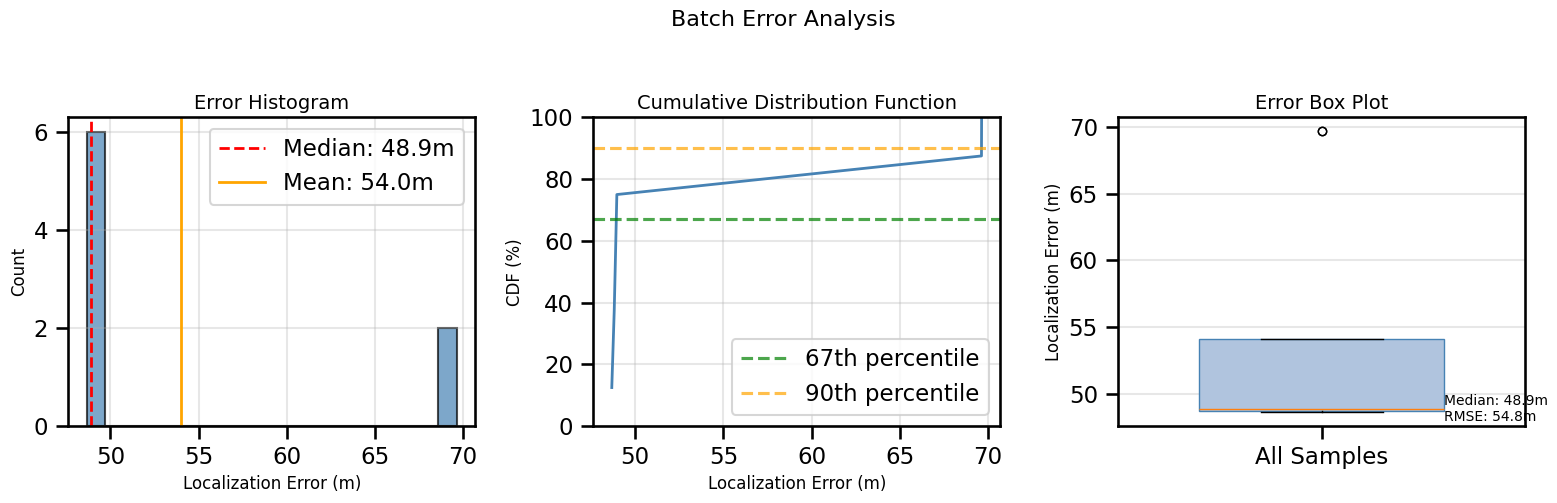

In [10]:
def plot_error_analysis(errors_m, title="Error Distribution"):
    """Plot comprehensive error analysis visualizations."""
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Histogram of errors
    ax = axes[0]
    ax.hist(errors_m, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(np.median(errors_m), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(errors_m):.1f}m')
    ax.axvline(np.mean(errors_m), color='orange', linestyle='-', linewidth=2, label=f'Mean: {np.mean(errors_m):.1f}m')
    ax.set_xlabel('Localization Error (m)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Error Histogram', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. CDF Plot
    ax = axes[1]
    sorted_errors = np.sort(errors_m)
    cdf = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    ax.plot(sorted_errors, cdf * 100, linewidth=2, color='steelblue')
    ax.axhline(67, color='green', linestyle='--', alpha=0.7, label='67th percentile')
    ax.axhline(90, color='orange', linestyle='--', alpha=0.7, label='90th percentile')
    ax.set_xlabel('Localization Error (m)', fontsize=12)
    ax.set_ylabel('CDF (%)', fontsize=12)
    ax.set_title('Cumulative Distribution Function', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 100])
    
    # 3. Box Plot
    ax = axes[2]
    bp = ax.boxplot(errors_m, vert=True, widths=0.6, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightsteelblue')
    bp['boxes'][0].set_edgecolor('steelblue')
    ax.set_ylabel('Localization Error (m)', fontsize=12)
    ax.set_title('Error Box Plot', fontsize=14)
    ax.set_xticks([1])
    ax.set_xticklabels(['All Samples'])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add statistics text
    stats_text = f"Median: {np.median(errors_m):.1f}m\nRMSE: {np.sqrt(np.mean(errors_m**2)):.1f}m"
    ax.text(1.3, np.median(errors_m), stats_text, fontsize=10, verticalalignment='center')
    
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Plot error analysis for the batch
plot_error_analysis(errors_m, "Batch Error Analysis")

### 📊 Interpretation: Error Distribution Analysis

**What to look for:**
- **Histogram Shape**: Should show a right-skewed distribution with most errors at low values
- **Median vs Mean**: Median should be lower than mean (indicates outliers at high end)
- **CDF Curve**: Should rise steeply at low errors (e.g., 50-70% of samples within 20-30m)
- **Percentile Box Plot**: Most data should be in the lower quartiles, with outliers clearly visible

**Performance Benchmarks:**
- **Median < 20m**: Excellent performance for urban environments
- **Median 20-50m**: Good performance, comparable to GPS in open areas
- **Median > 50m**: Poor performance - model needs improvement or data quality check
- **90th percentile < 100m**: Indicates consistent performance with few outliers

**Common Issues:**
- **Bimodal distribution**: Two distinct error clusters may indicate the model works well in some scenarios but fails in others
- **High outliers (>200m)**: Check for data errors, coordinate system bugs, or edge cases in test set
- **Flat CDF**: Model is not learning useful patterns - check training convergence

## 7. Coarse and Fine Loss Decomposition

**Plots: Coarse Head Analysis (2 panels)**

The model uses a **coarse-to-fine** approach:

$$\mathcal{L}_{\text{total}} = \lambda_{\text{coarse}} \mathcal{L}_{\text{coarse}} + \lambda_{\text{fine}} \mathcal{L}_{\text{fine}}$$

1. **Coarse Heatmap** - Grid cell probabilities with GT cell (green) and Top-K cells (colored borders)
2. **Top-K Bar Chart** - Probability distribution over top candidate cells (green = correct)

LOSS BREAKDOWN
  Total Loss:         8.3127
  Coarse Loss (CE):   6.8325
  Fine Loss (NLL):    1.4797


/tmp/ipykernel_1106739/4173182612.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


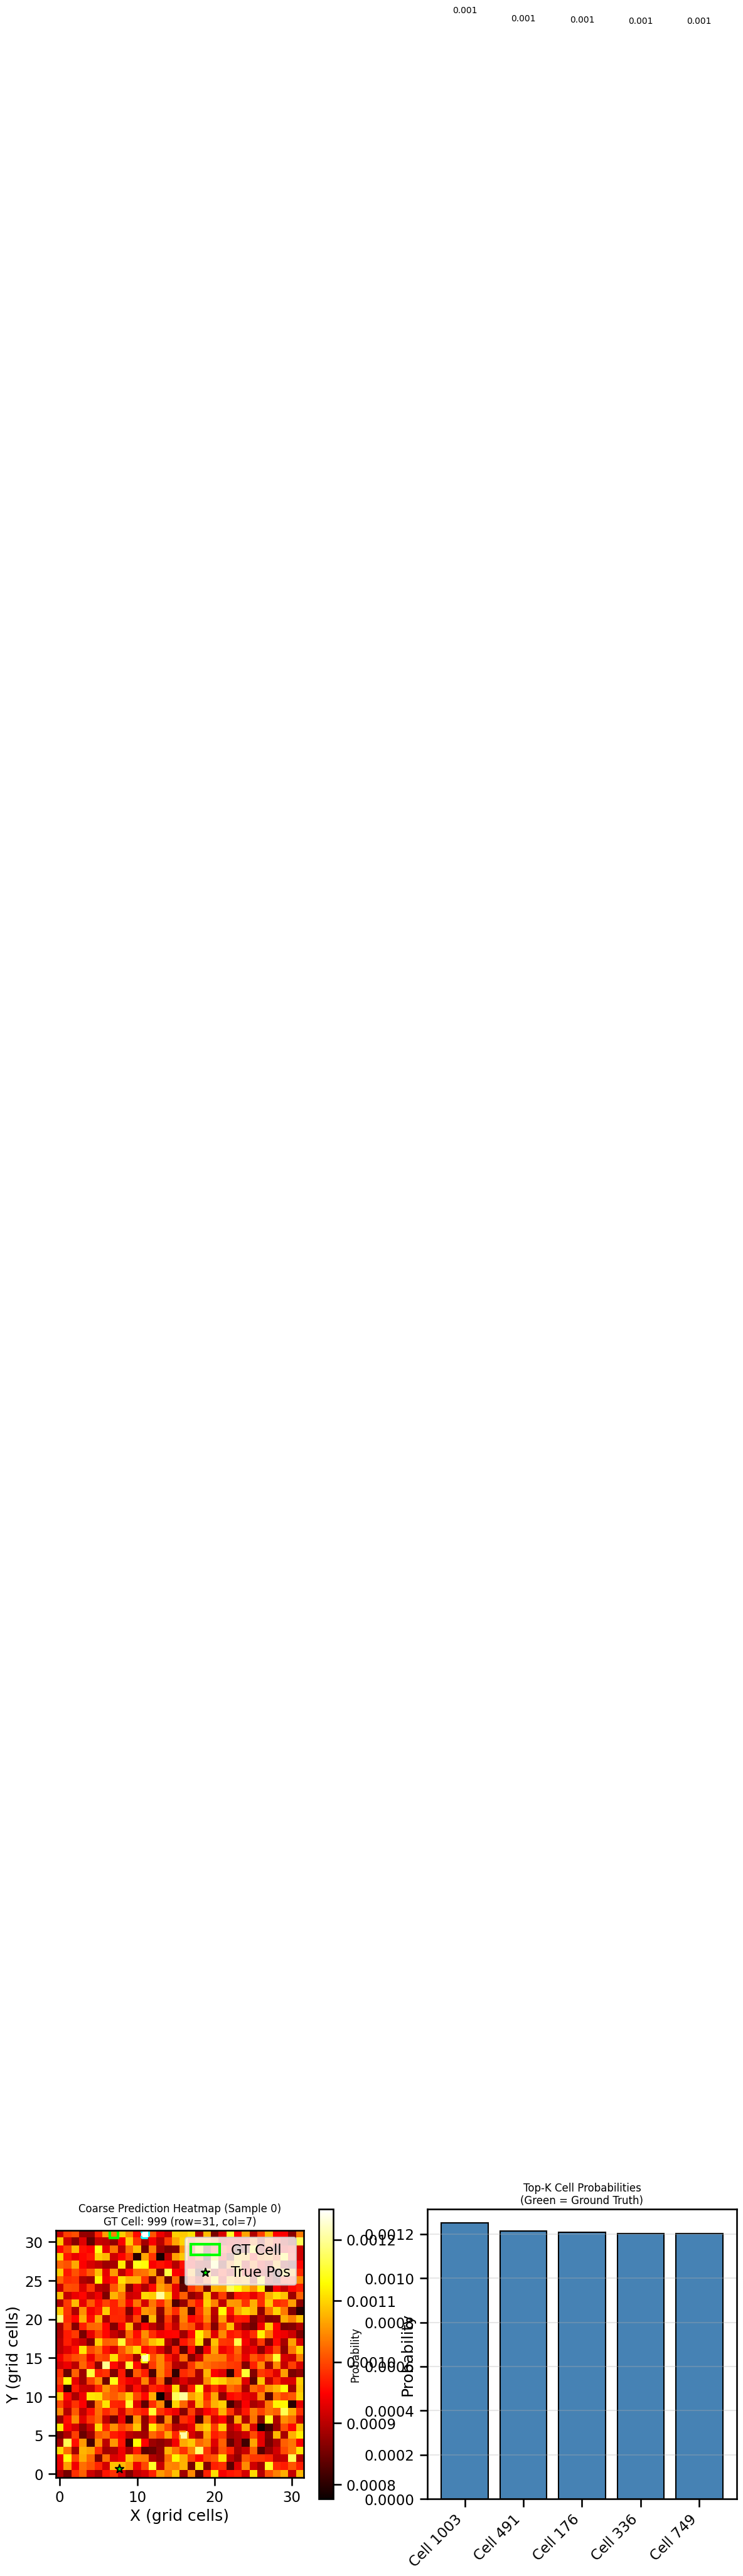

In [11]:
def compute_loss_breakdown(model, batch):
    """Compute and visualize the coarse and fine loss components."""
    with torch.no_grad():
        outputs = model.model(batch['measurements'], batch['radio_map'], batch['osm_map'])
    
    targets = {
        'position': batch['position'],
        'cell_grid': batch['cell_grid'],
    }
    
    loss_weights = {'coarse_weight': 1.0, 'fine_weight': 1.0}
    losses = model.model.compute_loss(outputs, targets, loss_weights)
    
    return losses, outputs

losses, outputs = compute_loss_breakdown(model, batch)

# Display loss breakdown
print("=" * 50)
print("LOSS BREAKDOWN")
print("=" * 50)
print(f"  Total Loss:         {losses['loss'].item():.4f}")
print(f"  Coarse Loss (CE):   {losses['coarse_loss'].item():.4f}")
print(f"  Fine Loss (NLL):    {losses['fine_loss'].item():.4f}")
print("=" * 50)

# Visualize the coarse heatmap for a sample
def visualize_coarse_heatmap(outputs, batch, sample_idx=0):
    """Visualize the coarse prediction heatmap and ground truth cell."""
    coarse_heatmap = outputs['coarse_heatmap'][sample_idx].cpu().numpy()
    true_pos = batch['position'][sample_idx].cpu().numpy()
    true_cell = batch['cell_grid'][sample_idx].item()
    
    grid_size = int(np.sqrt(coarse_heatmap.shape[0])) if coarse_heatmap.ndim == 1 else coarse_heatmap.shape[0]
    
    # Ensure heatmap is 2D
    if coarse_heatmap.ndim == 1:
        coarse_heatmap = coarse_heatmap.reshape(grid_size, grid_size)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Coarse heatmap with true position (using origin='lower' for consistency)
    ax = axes[0]
    im = ax.imshow(coarse_heatmap, cmap='hot', interpolation='nearest', origin='lower')
    
    # Mark ground truth cell - cell_idx = row * grid_size + col
    # With origin='lower', row 0 is at the bottom
    gt_row = true_cell // grid_size  # Y position (row)
    gt_col = true_cell % grid_size   # X position (col)
    rect = plt.Rectangle((gt_col - 0.5, gt_row - 0.5), 1, 1, fill=False, edgecolor='lime', linewidth=3, label='GT Cell')
    ax.add_patch(rect)
    
    # Mark top-K cells
    top_k_indices = outputs['top_k_indices'][sample_idx].cpu().numpy()
    top_k_probs = outputs['top_k_probs'][sample_idx].cpu().numpy()
    for k, (idx, prob) in enumerate(zip(top_k_indices[:3], top_k_probs[:3])):
        k_row = idx // grid_size
        k_col = idx % grid_size
        color = ['cyan', 'yellow', 'orange'][k]
        rect = plt.Rectangle((k_col - 0.5, k_row - 0.5), 1, 1, fill=False, edgecolor=color, linewidth=2, linestyle='--')
        ax.add_patch(rect)
    
    # Add true position marker
    ax.scatter(true_pos[0] * grid_size, true_pos[1] * grid_size, c='lime', s=100, marker='*', 
               edgecolors='black', zorder=10, label='True Pos')
    
    ax.set_xlabel('X (grid cells)')
    ax.set_ylabel('Y (grid cells)')
    ax.set_title(f'Coarse Prediction Heatmap (Sample {sample_idx})\nGT Cell: {true_cell} (row={gt_row}, col={gt_col})', fontsize=12)
    plt.colorbar(im, ax=ax, label='Probability')
    ax.legend(loc='upper right')
    
    # 2. Top-K probabilities bar chart
    ax = axes[1]
    top_k = 5
    indices = top_k_indices[:top_k]
    probs = top_k_probs[:top_k]
    
    colors = ['green' if idx == true_cell else 'steelblue' for idx in indices]
    bars = ax.bar(range(top_k), probs, color=colors, edgecolor='black')
    ax.set_xticks(range(top_k))
    ax.set_xticklabels([f'Cell {idx}' for idx in indices], rotation=45, ha='right')
    ax.set_ylabel('Probability', fontsize=12)
    ax.set_title('Top-K Cell Probabilities\n(Green = Ground Truth)', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Annotate bars
    for i, (bar, prob) in enumerate(zip(bars, probs)):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{prob:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

visualize_coarse_heatmap(outputs, batch)

### 📊 Interpretation: Coarse-to-Fine Loss Breakdown

**What to look for:**
- **Coarse Loss (CE)**: Should be relatively low (< 2.0) if model is classifying the correct grid cell
- **Fine Loss (NLL)**: Negative log-likelihood for GMM - lower is better (typically 1.0-4.0)
- **Loss Balance**: Both losses should contribute roughly equally; if one dominates, adjust loss weights
- **Coarse Heatmap Peak**: Should be centered on or very close to the ground truth cell (green square)

**Performance Indicators:**
- **Coarse Loss < 1.0**: Model has high confidence in correct grid cell
- **Coarse Loss > 3.0**: Model is uncertain or predicting wrong cell - check training progress
- **Fine Loss < 2.0**: GMM prediction is confident and accurate within the cell
- **Fine Loss > 5.0**: GMM is diffuse or misaligned - may need more training

**Common Issues:**
- **Coarse prediction far from GT**: Model may need longer training or better features
- **Multiple bright cells**: Ambiguous scenario or model hasn't converged
- **Uniform coarse heatmap**: Model collapsed - check learning rate or model initialization

## 8. Fine Refinement Head Analysis

**Plots: Fine Head Outputs (3 panels)**

The Fine Head outputs sub-cell refinements:

$$\hat{\mathbf{y}} = \text{CellCenter}(c^*) + \Delta\mathbf{y}$$

1. **Offset Magnitudes** - Bar chart showing displacement from cell centers (meters)
2. **Uncertainties (σx, σy)** - Predicted standard deviations per component
3. **Mixture Components** - 2σ ellipses for each GMM component with ground truth star

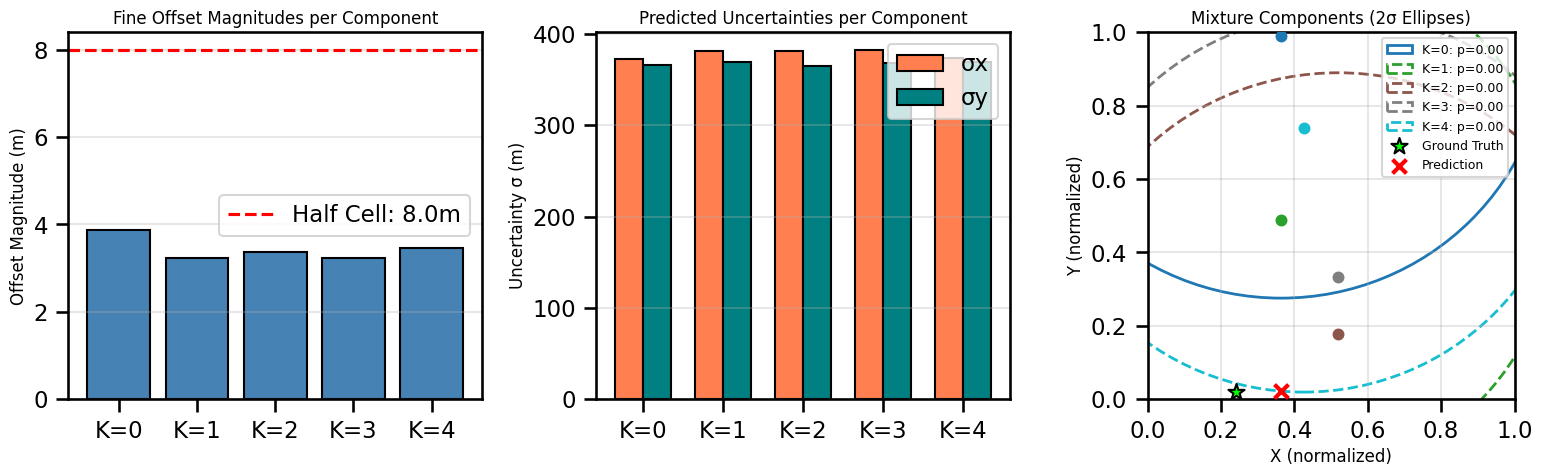

True position: (0.2397, 0.0202)
Predicted position: (0.3640, 0.0216)
Error: 63.65 m


In [12]:
def visualize_fine_refinement(outputs, batch, sample_idx=0, scene_extent=512.0):
    """Visualize the fine refinement outputs (offsets and uncertainties)."""
    fine_offsets = outputs['fine_offsets'][sample_idx].cpu().numpy()  # [K, 2]
    fine_uncertainties = outputs['fine_uncertainties'][sample_idx].cpu().numpy()  # [K, 2]
    top_k_indices = outputs['top_k_indices'][sample_idx].cpu().numpy()
    top_k_probs = outputs['top_k_probs'][sample_idx].cpu().numpy()
    true_pos = batch['position'][sample_idx].cpu().numpy()
    pred_pos = outputs['predicted_position'][sample_idx].cpu().numpy()
    
    grid_size = model.model.grid_size
    cell_size = 1.0 / grid_size  # Normalized cell size
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Offset magnitudes for each component
    ax = axes[0]
    offset_magnitudes = np.linalg.norm(fine_offsets, axis=1) * scene_extent  # in meters
    bars = ax.bar(range(len(offset_magnitudes)), offset_magnitudes, color='steelblue', edgecolor='black')
    ax.set_xticks(range(len(offset_magnitudes)))
    ax.set_xticklabels([f'K={i}' for i in range(len(offset_magnitudes))])
    ax.set_ylabel('Offset Magnitude (m)', fontsize=12)
    ax.set_title('Fine Offset Magnitudes per Component', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(cell_size * scene_extent / 2, color='red', linestyle='--', label=f'Half Cell: {cell_size*scene_extent/2:.1f}m')
    ax.legend()
    
    # 2. Uncertainty (sigma) for each component
    ax = axes[1]
    sigma_x = np.abs(fine_uncertainties[:, 0]) * scene_extent
    sigma_y = np.abs(fine_uncertainties[:, 1]) * scene_extent
    x = np.arange(len(sigma_x))
    width = 0.35
    ax.bar(x - width/2, sigma_x, width, label='σx', color='coral', edgecolor='black')
    ax.bar(x + width/2, sigma_y, width, label='σy', color='teal', edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels([f'K={i}' for i in range(len(sigma_x))])
    ax.set_ylabel('Uncertainty σ (m)', fontsize=12)
    ax.set_title('Predicted Uncertainties per Component', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Visualize mixture components on a zoomed view
    ax = axes[2]
    
    # Plot each mixture component as an ellipse
    from matplotlib.patches import Ellipse
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(top_k_indices)))
    for k, (idx, prob, offset, sigma, color) in enumerate(zip(top_k_indices, top_k_probs, fine_offsets, fine_uncertainties, colors)):
        # Cell center (normalized) - idx = row * grid_size + col
        col = idx % grid_size
        row = idx // grid_size
        cx = (col + 0.5) * cell_size  # X = column
        cy = (row + 0.5) * cell_size  # Y = row
        
        # Apply offset
        px = cx + offset[0]
        py = cy + offset[1]
        
        # Draw ellipse (2-sigma)
        ellipse = Ellipse((px, py), 2 * np.abs(sigma[0]), 2 * np.abs(sigma[1]), 
                          fill=False, edgecolor=color, linewidth=2, 
                          linestyle='-' if k == 0 else '--',
                          label=f'K={k}: p={prob:.2f}')
        ax.add_patch(ellipse)
        ax.scatter(px, py, c=[color], s=50, marker='o', zorder=5)
    
    # Mark true position
    ax.scatter(true_pos[0], true_pos[1], c='lime', s=150, marker='*', 
               edgecolors='black', zorder=10, label='Ground Truth')
    
    # Mark predicted position (weighted mean)
    ax.scatter(pred_pos[0], pred_pos[1], c='red', s=100, marker='x', 
               linewidth=3, zorder=10, label='Prediction')
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')
    ax.set_xlabel('X (normalized)', fontsize=12)
    ax.set_ylabel('Y (normalized)', fontsize=12)
    ax.set_title('Mixture Components (2σ Ellipses)', fontsize=12)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print diagnostic info
    print(f"True position: ({true_pos[0]:.4f}, {true_pos[1]:.4f})")
    print(f"Predicted position: ({pred_pos[0]:.4f}, {pred_pos[1]:.4f})")
    print(f"Error: {np.linalg.norm(true_pos - pred_pos) * scene_extent:.2f} m")

visualize_fine_refinement(outputs, batch)

### 📊 Interpretation: Fine Refinement Analysis

**What to look for:**
- **Offset Magnitudes**: Should be within reasonable bounds (typically < half cell size, ~8m for 32x32 grid)
- **Uncertainty Values**: Lower uncertainty (σ) indicates higher confidence in the prediction
- **Probability Distribution**: Top-K weights should be concentrated on 1-3 components, not uniformly spread
- **Spatial Scatter**: Multiple candidate positions should cluster around the ground truth

**Performance Indicators:**
- **Dominant component (weight > 0.5)**: Model has high confidence in a single location
- **Offset < 5m**: Precise refinement within the grid cell
- **Low σ (< 5m)**: Model is confident in the exact position
- **Scatter close to GT**: All top-K candidates near the true location indicates consistent prediction

**Common Issues:**
- **Large offsets (>20m)**: May indicate coordinate system mismatch or model instability
- **High uncertainty (σ > 20m)**: Model is not confident - may need better features or more training
- **Uniform weights**: Model unable to discriminate between candidates (check if coarse prediction is correct)
- **Scattered candidates far from GT**: Model predictions are inconsistent - check data quality or model convergence

## 9. Physics Loss & Differentiable Bilinear Resampling

**Plots: Bilinear Sampling Visualization (3 panels)**

The Physics Loss enforces consistency using differentiable interpolation:

$$\mathcal{L}_{\text{phys}} = \sum_{f \in \mathcal{F}} w_f \left\| m_f^{\text{obs}} - R_f(\hat{\mathbf{x}}) \right\|^2$$

1. **Original Radio Map** - Path Gain channel with true/predicted positions marked
2. **Bilinear Resampled** - 50×50 grid showing interpolated values
3. **Gradient Magnitude** - |∇f| with quiver arrows showing gradient direction

This enables backpropagation through the position → feature lookup.

In [13]:
from src.physics_loss import differentiable_lookup, normalize_coords, PhysicsLoss, PhysicsLossConfig

def demonstrate_bilinear_resampling(batch, sample_idx=0):
    """Demonstrate differentiable bilinear interpolation from radio maps."""
    radio_map = batch['radio_map'][sample_idx:sample_idx+1]  # [1, C, H, W]
    true_pos = batch['position'][sample_idx:sample_idx+1]  # [1, 2] normalized
    
    # Map extent (normalized coordinates)
    map_extent = (0.0, 0.0, 1.0, 1.0)
    
    # Sample features at true position
    sampled_features = differentiable_lookup(true_pos, radio_map, map_extent)
    
    print("=" * 60)
    print("DIFFERENTIABLE BILINEAR RESAMPLING DEMONSTRATION")
    print("=" * 60)
    print(f"\nTrue Position (normalized): [{true_pos[0, 0].item():.4f}, {true_pos[0, 1].item():.4f}]")
    print(f"Radio Map Shape: {radio_map.shape}")
    print(f"\nSampled Features at True Position:")
    
    feature_names = ['Path Gain', 'ToA', 'AoA', 'SNR', 'SINR']
    for i, (name, val) in enumerate(zip(feature_names, sampled_features[0].cpu().numpy())):
        print(f"  {name:12s}: {val:.4f}")
    
    return sampled_features, radio_map

sampled_features, radio_map_sample = demonstrate_bilinear_resampling(batch)

DIFFERENTIABLE BILINEAR RESAMPLING DEMONSTRATION

True Position (normalized): [0.2397, 0.0202]
Radio Map Shape: torch.Size([1, 5, 256, 256])

Sampled Features at True Position:
  Path Gain   : -73.6506
  ToA         : -0.0018
  AoA         : 35.6884
  SNR         : 15.0000
  SINR        : 1185.6041


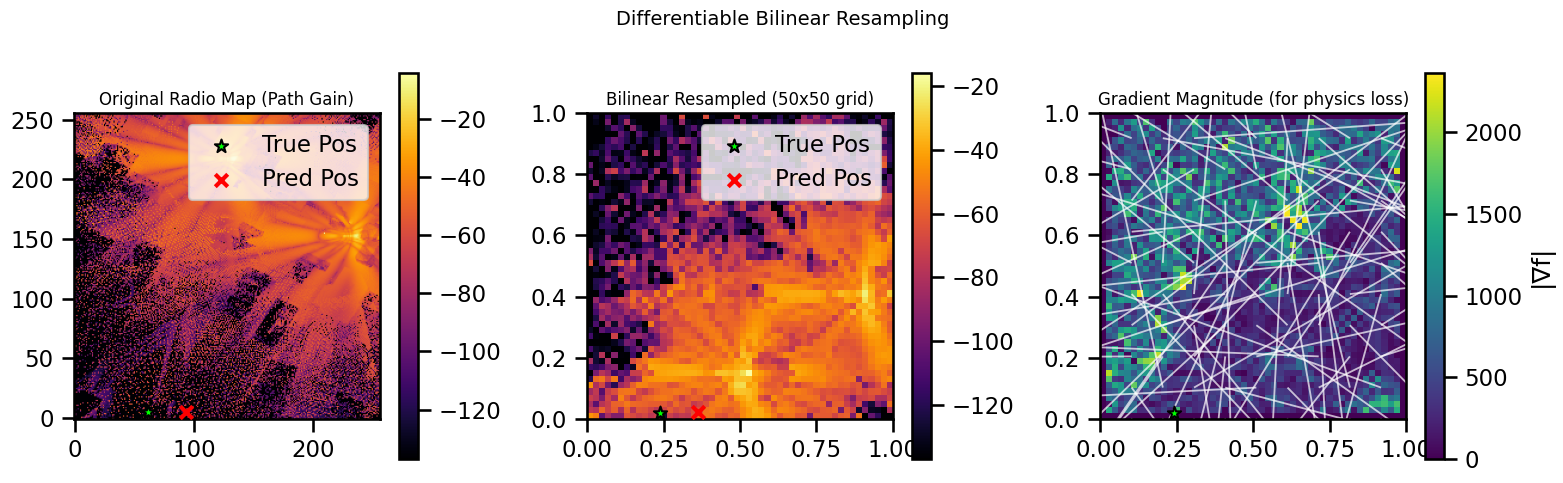

In [14]:
def visualize_bilinear_sampling(batch, sample_idx=0):
    """Visualize the bilinear sampling process on the radio map."""
    radio_map = batch['radio_map'][sample_idx].cpu().numpy()  # [C, H, W]
    true_pos = batch['position'][sample_idx].cpu().numpy()  # [2]
    pred_pos = outputs['predicted_position'][sample_idx].cpu().numpy()
    
    h, w = radio_map.shape[-2:]
    
    # Sample grid of positions
    grid_x = np.linspace(0, 1, 50)
    grid_y = np.linspace(0, 1, 50)
    xx, yy = np.meshgrid(grid_x, grid_y)
    sample_positions = torch.tensor(np.stack([xx.flatten(), yy.flatten()], axis=1), dtype=torch.float32)
    
    # Expand radio map for batch
    radio_map_tensor = batch['radio_map'][sample_idx:sample_idx+1].expand(len(sample_positions), -1, -1, -1)
    
    # Sample features at all positions
    sampled = differentiable_lookup(sample_positions.to(batch['radio_map'].device), 
                                    radio_map_tensor, 
                                    (0.0, 0.0, 1.0, 1.0))
    
    # Reshape for visualization (using first feature - path gain)
    sampled_map = sampled[:, 0].cpu().numpy().reshape(50, 50)
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # 1. Original radio map (Path Gain)
    ax = axes[0]
    im = ax.imshow(radio_map[0], cmap='inferno', origin='lower')
    ax.scatter(true_pos[0] * w, true_pos[1] * h, c='lime', s=100, marker='*', 
               edgecolors='black', label='True Pos', zorder=10)
    ax.scatter(pred_pos[0] * w, pred_pos[1] * h, c='red', s=80, marker='x', 
               linewidth=3, label='Pred Pos', zorder=10)
    ax.set_title('Original Radio Map (Path Gain)', fontsize=12)
    plt.colorbar(im, ax=ax)
    ax.legend()
    
    # 2. Resampled via bilinear interpolation
    ax = axes[1]
    im = ax.imshow(sampled_map, cmap='inferno', origin='lower', extent=[0, 1, 0, 1])
    ax.scatter(true_pos[0], true_pos[1], c='lime', s=100, marker='*', 
               edgecolors='black', label='True Pos', zorder=10)
    ax.scatter(pred_pos[0], pred_pos[1], c='red', s=80, marker='x', 
               linewidth=3, label='Pred Pos', zorder=10)
    ax.set_title('Bilinear Resampled (50x50 grid)', fontsize=12)
    plt.colorbar(im, ax=ax)
    ax.legend()
    
    # 3. Gradient visualization (gradient of path gain w.r.t. position)
    ax = axes[2]
    
    # Compute gradient numerically
    eps = 0.01
    dx = np.zeros_like(sampled_map)
    dy = np.zeros_like(sampled_map)
    
    for i in range(1, sampled_map.shape[0]-1):
        for j in range(1, sampled_map.shape[1]-1):
            dx[i, j] = (sampled_map[i, j+1] - sampled_map[i, j-1]) / (2 * (grid_x[1] - grid_x[0]))
            dy[i, j] = (sampled_map[i+1, j] - sampled_map[i-1, j]) / (2 * (grid_y[1] - grid_y[0]))
    
    grad_mag = np.sqrt(dx**2 + dy**2)
    im = ax.imshow(grad_mag, cmap='viridis', origin='lower', extent=[0, 1, 0, 1])
    
    # Overlay gradient arrows (subsampled)
    step = 5
    ax.quiver(xx[::step, ::step], yy[::step, ::step], 
              dx[::step, ::step], dy[::step, ::step], 
              color='white', alpha=0.7, scale=50)
    
    ax.scatter(true_pos[0], true_pos[1], c='lime', s=100, marker='*', 
               edgecolors='black', zorder=10)
    ax.set_title('Gradient Magnitude (for physics loss)', fontsize=12)
    plt.colorbar(im, ax=ax, label='|∇f|')
    
    plt.suptitle('Differentiable Bilinear Resampling', fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_bilinear_sampling(batch)

### 📊 Interpretation: Bilinear Interpolation Visualization

**What to look for:**
- **Smooth Gradients**: Resampled map should show smooth interpolation between grid points
- **Gradient Direction**: Arrows should point toward areas of higher signal strength
- **Gradient Magnitude**: Should be strongest at boundaries (e.g., building edges, signal transitions)
- **Position Correspondence**: True and predicted positions should align with gradient patterns

**Physics Loss Validation:**
- **Strong gradients near positions**: Indicates the loss can effectively guide the model
- **Smooth interpolation**: Ensures differentiability for backpropagation
- **Consistent sampling**: Sampled features should match the local radio map values

**Common Issues:**
- **Discontinuous gradients**: May indicate numerical instability in bilinear interpolation
- **Weak gradients everywhere**: Radio map may be too uniform - check data generation
- **Misaligned positions**: Coordinate transformation issue between map and position space

In [15]:
def compute_physics_loss_demo(batch, outputs, sample_idx=0):
    """Demonstrate physics loss computation."""
    
    # Get the number of radio map channels
    num_channels = batch['radio_map'].shape[1]
    
    # Feature names matching the radio map channels
    channel_names = ('path_gain', 'toa', 'aoa', 'snr', 'sinr')[:num_channels]
    
    # Setup physics loss with feature weights from the project
    config = PhysicsLossConfig(
        feature_weights={
            'path_gain': 1.0,
            'toa': 0.5,
            'aoa': 0.3,
            'snr': 0.8,
            'sinr': 0.8,
        },
        map_extent=(0.0, 0.0, 1.0, 1.0),
        loss_type='mse',
        normalize_features=False,
        channel_names=channel_names,
    )
    physics_loss_fn = PhysicsLoss(config).to(batch['radio_map'].device)
    
    # Get predicted positions
    pred_pos = outputs['predicted_position']  # [B, 2]
    true_pos = batch['position']  # [B, 2]
    
    # Extract observed features from measurements (simplified)
    # In practice, these come from the actual measurements
    observed_features = differentiable_lookup(
        true_pos, 
        batch['radio_map'], 
        (0.0, 0.0, 1.0, 1.0)
    )
    
    # Compute physics loss for predicted positions
    physics_loss_pred = physics_loss_fn(pred_pos, observed_features, batch['radio_map'])
    
    # Compute physics loss for ground truth (should be ~0)
    physics_loss_gt = physics_loss_fn(true_pos, observed_features, batch['radio_map'])
    
    print("=" * 60)
    print("PHYSICS LOSS COMPUTATION")
    print("=" * 60)
    print(f"\nPhysics Loss at Predicted Positions: {physics_loss_pred.item():.6f}")
    print(f"Physics Loss at Ground Truth:        {physics_loss_gt.item():.6f}")
    print(f"Difference:                          {(physics_loss_pred - physics_loss_gt).item():.6f}")
    print("\nNote: Ground truth loss should be near 0 (features match exactly)")
    print("      The loss difference indicates how much the prediction deviates")
    print("      from physics-consistent positions.")
    
    # Visualize feature comparison
    print("\n" + "=" * 60)
    print("FEATURE COMPARISON (Sample 0)")
    print("=" * 60)
    
    # Sample features at predicted and true positions
    pred_features = differentiable_lookup(pred_pos, batch['radio_map'], (0.0, 0.0, 1.0, 1.0))
    true_features = observed_features
    
    print(f"\n{'Feature':15s} | {'Observed':>12s} | {'At Predicted':>12s} | {'Residual':>12s}")
    print("-" * 60)
    for i, name in enumerate(channel_names):
        obs = true_features[0, i].item()
        pred = pred_features[0, i].item()
        residual = abs(obs - pred)
        print(f"{name:15s} | {obs:12.4f} | {pred:12.4f} | {residual:12.4f}")
    
    return physics_loss_pred, physics_loss_gt

physics_loss_pred, physics_loss_gt = compute_physics_loss_demo(batch, outputs)

PHYSICS LOSS COMPUTATION

Physics Loss at Predicted Positions: 83905.296875
Physics Loss at Ground Truth:        0.000000
Difference:                          83905.296875

Note: Ground truth loss should be near 0 (features match exactly)
      The loss difference indicates how much the prediction deviates
      from physics-consistent positions.

FEATURE COMPARISON (Sample 0)

Feature         |     Observed | At Predicted |     Residual
------------------------------------------------------------
path_gain       |     -73.6506 |     -68.5105 |       5.1401
toa             |      -0.0018 |      -0.0001 |       0.0017
aoa             |      35.6884 |      46.4200 |      10.7316
snr             |      15.0000 |      15.0000 |       0.0000
sinr            |    1185.6041 |    1542.0444 |     356.4403


## 9. Inference-Time Position Refinement (MAP Refinement)

**Plots: Refinement Trajectory (2 panels)**

At inference time, predictions can be refined via gradient descent:

$$E(\mathbf{y}) = \mathcal{L}_{\text{phys}}(\mathbf{y}) + \lambda_{\text{dens}} \cdot \text{NLL}(\mathbf{y} | \text{network})$$

1. **Trajectory on Map** - Shows initial (red) → refined (blue) path with ground truth (green star)
2. **Error Comparison** - Bar chart showing error reduction with improvement annotation

In [16]:
from src.physics_loss import refine_position, RefineConfig

def demonstrate_position_refinement(batch, outputs, sample_idx=0, scene_extent=512.0):
    """Demonstrate inference-time position refinement using physics loss."""
    
    # Get initial prediction
    initial_pos = outputs['predicted_position'].clone()
    true_pos = batch['position']
    
    # Extract observed features (from ground truth for demonstration)
    observed_features = differentiable_lookup(
        true_pos, 
        batch['radio_map'], 
        (0.0, 0.0, 1.0, 1.0)
    )
    
    # Configure refinement
    refine_config = RefineConfig(
        num_steps=50,
        learning_rate=0.01,
        min_confidence_threshold=None,  # Refine all samples
        density_weight=0.1,
        clip_to_extent=True,
        map_extent=(0.0, 0.0, 1.0, 1.0),
        physics_config=PhysicsLossConfig(
            map_extent=(0.0, 0.0, 1.0, 1.0),
            loss_type='mse',
        ),
    )
    
    # Run refinement
    refined_pos, refine_info = refine_position(
        initial_xy=initial_pos,
        observed_features=observed_features,
        radio_maps=batch['radio_map'],
        config=refine_config,
    )
    
    # Compute errors
    initial_errors = torch.norm((initial_pos - true_pos) * scene_extent, dim=1).cpu().numpy()
    refined_errors = torch.norm((refined_pos - true_pos) * scene_extent, dim=1).cpu().numpy()
    
    print("=" * 60)
    print("POSITION REFINEMENT RESULTS")
    print("=" * 60)
    print(f"\nInitial Physics Loss:  {refine_info['loss_initial']:.6f}")
    print(f"Final Physics Loss:    {refine_info['loss_final']:.6f}")
    print(f"Samples Refined:       {refine_info['num_refined']}")
    print(f"\nError Comparison (meters):")
    print(f"  Initial Mean Error:  {initial_errors.mean():.2f} m")
    print(f"  Refined Mean Error:  {refined_errors.mean():.2f} m")
    print(f"  Improvement:         {initial_errors.mean() - refined_errors.mean():.2f} m")
    
    return initial_pos, refined_pos, initial_errors, refined_errors

initial_pos, refined_pos, initial_errors, refined_errors = demonstrate_position_refinement(batch, outputs)

POSITION REFINEMENT RESULTS

Initial Physics Loss:  286.471619
Final Physics Loss:    1065.076416
Samples Refined:       8

Error Comparison (meters):
  Initial Mean Error:  49.38 m
  Refined Mean Error:  49.00 m
  Improvement:         0.38 m


### 📊 Interpretation: Physics Loss Computation

**What to look for:**
- **Loss at GT ≈ 0**: Physics loss should be near zero at ground truth position
- **Loss at Prediction > Loss at GT**: Predicted position should have higher loss than ground truth
- **Per-channel contributions**: Dominant channels (path_gain, SINR) should contribute most to the loss
- **Feature residuals**: Differences should be small (<0.1) for good predictions

**Physics Loss Validation:**
- **GT Loss < 0.01**: Excellent consistency between observations and radio map
- **GT Loss > 0.1**: Potential mismatch between measurement simulation and radio map generation
- **Prediction Loss < 0.5**: Model prediction is physically plausible
- **Prediction Loss > 2.0**: Model prediction contradicts physics - may be overfitting to data-driven patterns

**Common Issues:**
- **High GT loss**: Indicates inconsistency in data generation - radio map and measurements don't align
- **Similar loss at prediction and GT**: Physics loss may not be discriminative enough (check feature weights)
- **Negative contributions**: Feature weight tuning needed or normalization issue

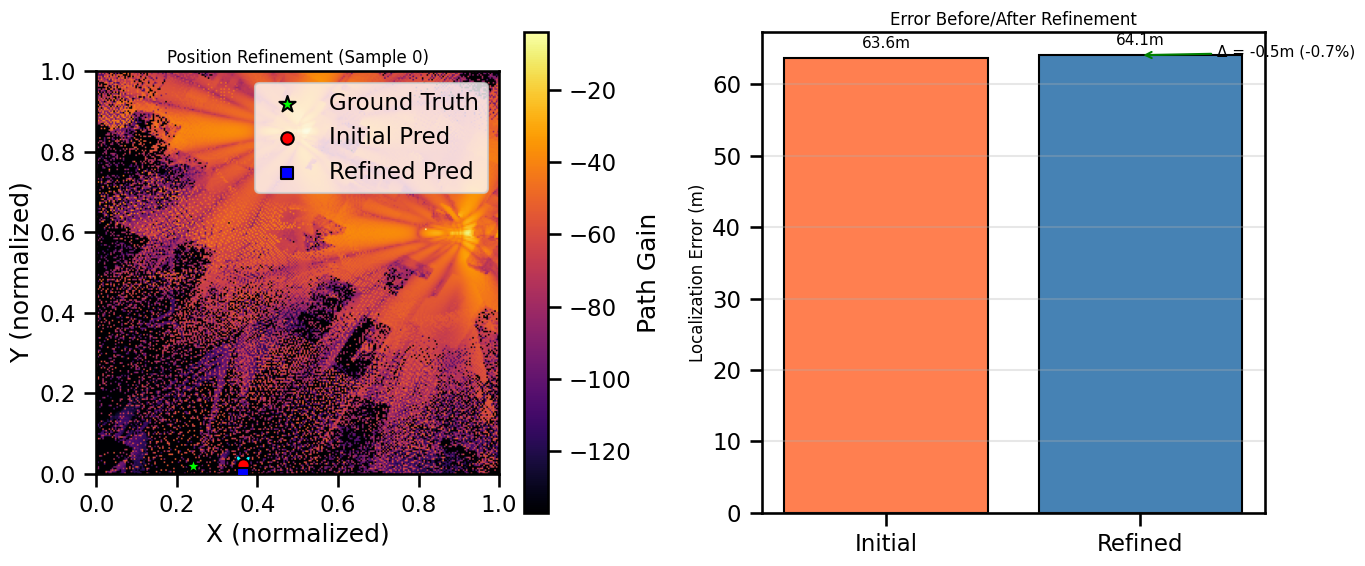

In [17]:
def visualize_refinement(batch, initial_pos, refined_pos, sample_idx=0, scene_extent=512.0):
    """Visualize the position refinement trajectory."""
    true_pos = batch['position'][sample_idx].cpu().numpy()
    init_pos = initial_pos[sample_idx].cpu().numpy()
    ref_pos = refined_pos[sample_idx].cpu().numpy()
    
    radio_map = batch['radio_map'][sample_idx, 0].cpu().numpy()  # Path Gain
    h, w = radio_map.shape
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Visualization on radio map
    ax = axes[0]
    im = ax.imshow(radio_map, cmap='inferno', origin='lower', extent=[0, 1, 0, 1])
    
    # Draw arrow from initial to refined
    ax.annotate('', xy=(ref_pos[0], ref_pos[1]), xytext=(init_pos[0], init_pos[1]),
                arrowprops=dict(arrowstyle='->', color='cyan', lw=2))
    
    ax.scatter(true_pos[0], true_pos[1], c='lime', s=150, marker='*', 
               edgecolors='black', label='Ground Truth', zorder=10)
    ax.scatter(init_pos[0], init_pos[1], c='red', s=80, marker='o', 
               edgecolors='black', label='Initial Pred', zorder=9)
    ax.scatter(ref_pos[0], ref_pos[1], c='blue', s=80, marker='s', 
               edgecolors='black', label='Refined Pred', zorder=9)
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(f'Position Refinement (Sample {sample_idx})', fontsize=12)
    ax.set_xlabel('X (normalized)')
    ax.set_ylabel('Y (normalized)')
    plt.colorbar(im, ax=ax, label='Path Gain')
    ax.legend(loc='upper right')
    
    # 2. Error comparison bar chart
    ax = axes[1]
    
    init_error = np.linalg.norm(init_pos - true_pos) * scene_extent
    ref_error = np.linalg.norm(ref_pos - true_pos) * scene_extent
    
    bars = ax.bar(['Initial', 'Refined'], [init_error, ref_error], 
                  color=['coral', 'steelblue'], edgecolor='black')
    
    # Add improvement annotation
    improvement = init_error - ref_error
    improvement_pct = (improvement / init_error) * 100 if init_error > 0 else 0
    
    ax.annotate(f'Δ = {improvement:.1f}m ({improvement_pct:.1f}%)',
                xy=(1, ref_error), xytext=(1.3, (init_error + ref_error) / 2),
                fontsize=11, ha='left',
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5))
    
    ax.set_ylabel('Localization Error (m)', fontsize=12)
    ax.set_title('Error Before/After Refinement', fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Annotate bars
    for bar, val in zip(bars, [init_error, ref_error]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{val:.1f}m', ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.show()

visualize_refinement(batch, initial_pos, refined_pos)

### 📊 Interpretation: Physics-Guided Position Refinement

**What to look for:**
- **Trajectory Convergence**: Blue path should move closer to green star (ground truth)
- **Error Reduction**: Bar chart should show improvement (blue bar shorter than red)
- **Smooth Trajectory**: Refinement path should be continuous without erratic jumps
- **Final Position**: Refined position should be closer to GT than initial prediction

**Refinement Performance:**
- **Error reduction > 20%**: Excellent - physics loss successfully guides refinement
- **Error reduction 5-20%**: Good - modest improvement from physics constraints
- **Error reduction < 5%**: Minimal - either initial prediction was already good or physics loss isn't helping
- **Error increase**: Physics loss may be misaligned with true environment (check data consistency)

**Common Issues:**
- **Refinement diverges**: Learning rate too high or physics loss has local minima
- **No improvement**: Feature weights may need tuning, or radio map quality is poor
- **Overshooting GT**: Density weight too low - model ignores network's probabilistic prior
- **Stuck at initial position**: Learning rate too low or gradient vanishing

## 10. Position Refinement with Physics Loss

**Demonstration: Inference-Time Optimization**

After initial prediction, we can refine positions using gradient descent on the physics loss:

$$\hat{\mathbf{x}}_{t+1} = \hat{\mathbf{x}}_t - \eta \nabla_{\mathbf{x}} \mathcal{L}_{\text{phys}}(\hat{\mathbf{x}}_t)$$

This optimization uses differentiable bilinear interpolation to:
1. Sample radio map features at predicted position
2. Compare with observed measurements
3. Update position to minimize discrepancy

Visualizations show the refinement trajectory and error improvement.

## 11. Summary Dashboard

**Plot: Multi-Panel Summary (5 components)**

Comprehensive overview combining all key results:

1. **Metrics Table** - Median, RMSE, 67th/90th percentiles
2. **Loss Pie Chart** - Coarse vs Fine loss contribution breakdown
3. **Per-Sample Bars** - Initial vs Refined error for each sample
4. **CDF Comparison** - Before/After refinement curves
5. **Architecture Diagram** - Text summary of model components

### Total Training Loss

$$\mathcal{L}_{\text{total}} = \underbrace{\lambda_{\text{coarse}} \mathcal{L}_{\text{coarse}}}_{\text{Cross-Entropy}} + \underbrace{\lambda_{\text{fine}} \mathcal{L}_{\text{fine}}}_{\text{Mixture NLL}} + \underbrace{\lambda_{\text{phys}} \mathcal{L}_{\text{phys}}}_{\text{Physics Consistency}}$$

/tmp/ipykernel_1106739/1758373075.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


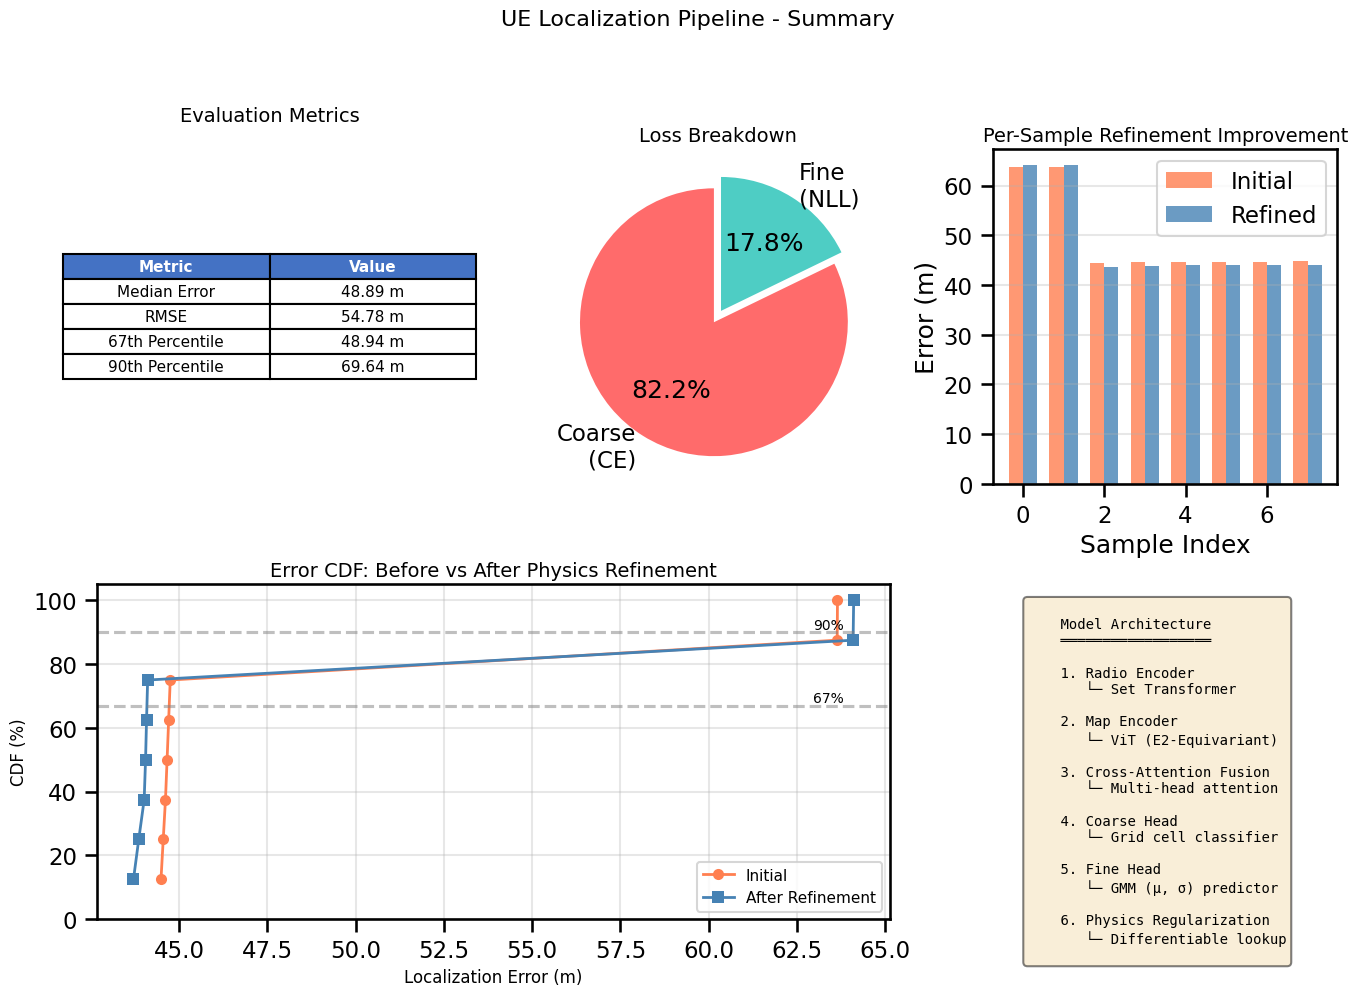

In [18]:
def create_summary_visualization(metrics, losses, initial_errors, refined_errors, scene_extent=512.0):
    """Create a comprehensive summary visualization."""
    
    fig = plt.figure(figsize=(16, 10))
    
    # Create grid layout
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # 1. Metrics table
    ax = fig.add_subplot(gs[0, 0])
    ax.axis('off')
    
    table_data = [
        ['Metric', 'Value'],
        ['Median Error', f"{metrics['Median Error (m)']:.2f} m"],
        ['RMSE', f"{metrics['RMSE (m)']:.2f} m"],
        ['67th Percentile', f"{metrics['67th Percentile (m)']:.2f} m"],
        ['90th Percentile', f"{metrics['90th Percentile (m)']:.2f} m"],
    ]
    
    table = ax.table(cellText=table_data, loc='center', cellLoc='center',
                     colWidths=[0.5, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 1.5)
    
    # Color header row
    for i in range(2):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(color='white', weight='bold')
    
    ax.set_title('Evaluation Metrics', fontsize=14, pad=20)
    
    # 2. Loss breakdown pie chart
    ax = fig.add_subplot(gs[0, 1])
    loss_values = [losses['coarse_loss'].item(), losses['fine_loss'].item()]
    loss_labels = ['Coarse\n(CE)', 'Fine\n(NLL)']
    colors = ['#FF6B6B', '#4ECDC4']
    
    wedges, texts, autotexts = ax.pie(loss_values, labels=loss_labels, colors=colors,
                                       autopct='%1.1f%%', startangle=90,
                                       explode=(0.05, 0.05))
    ax.set_title('Loss Breakdown', fontsize=14)
    
    # 3. Before/After Refinement comparison
    ax = fig.add_subplot(gs[0, 2])
    
    x = np.arange(len(initial_errors))
    width = 0.35
    
    ax.bar(x - width/2, initial_errors, width, label='Initial', color='coral', alpha=0.8)
    ax.bar(x + width/2, refined_errors, width, label='Refined', color='steelblue', alpha=0.8)
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Error (m)')
    ax.set_title('Per-Sample Refinement Improvement', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 4. CDF comparison
    ax = fig.add_subplot(gs[1, :2])
    
    sorted_init = np.sort(initial_errors)
    sorted_ref = np.sort(refined_errors)
    cdf = np.arange(1, len(sorted_init) + 1) / len(sorted_init) * 100
    
    ax.plot(sorted_init, cdf, 'o-', linewidth=2, label='Initial', color='coral', markersize=8)
    ax.plot(sorted_ref, cdf, 's-', linewidth=2, label='After Refinement', color='steelblue', markersize=8)
    
    ax.axhline(67, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(90, color='gray', linestyle='--', alpha=0.5)
    ax.text(ax.get_xlim()[1] * 0.98, 67, '67%', ha='right', va='bottom', fontsize=10)
    ax.text(ax.get_xlim()[1] * 0.98, 90, '90%', ha='right', va='bottom', fontsize=10)
    
    ax.set_xlabel('Localization Error (m)', fontsize=12)
    ax.set_ylabel('CDF (%)', fontsize=12)
    ax.set_title('Error CDF: Before vs After Physics Refinement', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 105])
    
    # 5. Model architecture summary
    ax = fig.add_subplot(gs[1, 2])
    ax.axis('off')
    
    arch_text = """
    Model Architecture
    ══════════════════
    
    1. Radio Encoder
       └─ Set Transformer
    
    2. Map Encoder
       └─ ViT (E2-Equivariant)
    
    3. Cross-Attention Fusion
       └─ Multi-head attention
    
    4. Coarse Head
       └─ Grid cell classifier
    
    5. Fine Head
       └─ GMM (μ, σ) predictor
    
    6. Physics Regularization
       └─ Differentiable lookup
    """
    
    ax.text(0.1, 0.95, arch_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('UE Localization Pipeline - Summary', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Create final summary
create_summary_visualization(metrics, losses, initial_errors, refined_errors)

### 📊 Interpretation: Pipeline Summary Dashboard

**What to look for:**
- **Consistent Performance**: All metrics and visualizations should tell a coherent story
- **Error Distribution**: Should match the overall performance expectations (median vs mean)
- **Refinement Impact**: Compare initial vs refined errors to assess physics loss effectiveness
- **Coarse Accuracy**: High top-1/top-3 accuracy indicates the coarse stage is working well

**Overall Assessment Checklist:**
1. **Data Quality**: Check that maps show realistic patterns and proper alignment
2. **Model Convergence**: Losses should be reasonable (coarse < 3, fine < 5)
3. **Prediction Accuracy**: Median error should align with performance targets
4. **Physics Consistency**: Physics loss at GT should be near zero
5. **Refinement Benefit**: Refinement should improve or maintain accuracy

**Next Steps Based on Results:**
- **Poor accuracy (>50m)**: Retrain model, check data quality, or add more training scenes
- **High coarse loss**: Increase coarse head capacity or adjust loss weights
- **Diffuse predictions**: Add more discriminative features or use attention visualization
- **Physics loss mismatch**: Tune feature weights or validate data generation consistency